# TO DO:

- interbout interval analysis
- variance ANOVA
- fix graphs

# Imports

In [130]:
import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.stats import norm
from scipy import stats
import seaborn as sns
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d
import matplotlib.font_manager as font_manager
from scipy.optimize import curve_fit
import math
from scipy.special import expit
from scipy import signal
import pingouin as pg

# Division / Preprocessing Functions

In [2]:
def divide_data_by_flow_direction(data):
    '''Dividing raw data from one fish into 2 dataframes with either left or right OMR flow'''
    data.columns = ['X_coord', 'Y_coord', 'heading_direction', \
                'cumulative_direction','beat_freq', 'beat_amp', \
                'tail_move?', 'timestamp', 'contrast_level', 'flow_direction']
    right = pd.DataFrame(data[data.flow_direction == 1])
    left = pd.DataFrame(data[data.flow_direction == 2])
    zero = pd.DataFrame(data[data.flow_direction == 0])

    return right, left, zero

def divide_data_by_contrast(data):
    '''Dividing raw data from one fish and one flow direction into contrast levels'''
    C_0 = pd.DataFrame(data[data.contrast_level == 0])
    C_01 = pd.DataFrame(data[data.contrast_level == 0.01])
    C_1 = pd.DataFrame(data[data.contrast_level == 0.1])
    C_2 = pd.DataFrame(data[data.contrast_level == 0.2])
    C_3 = pd.DataFrame(data[data.contrast_level == 0.3])
    C_5 = pd.DataFrame(data[data.contrast_level == 0.5])
    C_7 = pd.DataFrame(data[data.contrast_level == 0.7])
    C_10 = pd.DataFrame(data[data.contrast_level == 1])
    return C_0, C_01, C_1, C_2, C_3, C_5, C_7, C_10

def omr_preprocess(data):
    # remove timestamp and extras
    # keep x, y, heading, cumulative, timestamp
    data.columns = ['X_coord', 'Y_coord', 'heading_direction', \
                'cumulative_direction','beat_freq', 'beat_amp', \
                'tail_move?', 'timestamp', 'contrast_level', 'flow_direction']
    new = data.drop(columns = ['beat_freq', 'beat_amp','tail_move?', 'contrast_level', 'flow_direction'])


    # resetting index
    new = pd.DataFrame(new)
    new = new.set_index('timestamp').reset_index()


    # remove time points where there was an angle change of more than pi from one frame to another
    for i, row in new.iterrows():
        if i+1 == len(new):
            break
            # modify to add the exclusion zone
        if np.abs(new.at[i+1,'cumulative_direction']-new.at[i,'cumulative_direction']) >= 2.5:
            new.at[i+1, 'cumulative_direction'] = new.at[i,'cumulative_direction']


    # interpolating and normalising data to a fixed set of points
    interp = pd.DataFrame(columns=['timestamp','X_coord','Y_coord','heading_direction','cumulative_direction'])
    for column in new.columns:
        x = np.arange(0,len(new))
        y = new[column]
        f = interpolate.interp1d(x,y)

        x_new = np.arange(0,3000,1)
        y_new = f(x_new)
        interp[column] = y_new


    # setting first cumulative_angle to zero and ajdusting all others
    interp.iloc[:,4] -= interp.iloc[0,4]


    # calculating distance traveled between each timeframe
    # distance = sqrt((x2-x1)**2 + (y2-y1)**2)
    interp['distance_pts'] = 0
    for row in range(1,len(interp),1):
        distance = np.sqrt((interp['X_coord'][row]-interp['X_coord'][row-1])**2\
                            +(interp['Y_coord'][row]-interp['Y_coord'][row-1])**2)
        interp.iloc[row,5] = distance


    # cleaning the timestamps
    interp.insert(0, 'new_timestamp', range(1, 1 + len(interp)))
    interp = interp.drop(columns=['timestamp']).rename(columns={'new_timestamp':'timestamp'})
    interp['timestamp'] = interp['timestamp']/100

    return np.array(interp)

def combine_fish_data(*args):
    '''Combines preprocessed data from all fish into a 3D numpy array'''
    combined_fish = np.stack((args),axis=0)
    return combined_fish

# Reading / Preprocessing Files

In [3]:
for e in range(1,19):
    exec(f'pm_e{e} = pd.read_csv("../raw_data/PM/E2/xy_hc_fai_tstp_E2_{e}_PM.csv")')
    
for e in range(1,19):
    exec(f'pm_Re{e},pm_Le{e},pm_Ze{e} = divide_data_by_flow_direction(pm_e{e})')

for flow in ['R','L','Z']:
    for e in range(1,19):
        exec(f'pm_{flow}e{e}C_0, pm_{flow}e{e}C_1, pm_{flow}e{e}C_10, pm_{flow}e{e}C_20, pm_{flow}e{e}C_30, \
            pm_{flow}e{e}C_50, pm_{flow}e{e}C_70, pm_{flow}e{e}C_100 = divide_data_by_contrast(pm_{flow}e{e})')

for flow in ['R','L']:
    for contrast in ['1','10','20','30','50','70','100']:
        for e in range(1,19):
            exec(f'pm_{flow}e{e}C_{contrast} = omr_preprocess(pm_{flow}e{e}C_{contrast})')

In [4]:
for me in range(1,23):
    exec(f'pm_me{me} = pd.read_csv("../raw_data/PM/Met/xy_hc_fai_tstp_Me_{me}_PM.csv")')
    
for me in range(1,23):
    exec(f'pm_Rme{me},pm_Lme{me},pm_Zme{me} = divide_data_by_flow_direction(pm_me{me})')

for flow in ['R','L','Z']:
    for me in range(1,23):
        exec(f'pm_{flow}me{me}C_0, pm_{flow}me{me}C_1, pm_{flow}me{me}C_10, pm_{flow}me{me}C_20, pm_{flow}me{me}C_30, \
            pm_{flow}me{me}C_50, pm_{flow}me{me}C_70, pm_{flow}me{me}C_100 = divide_data_by_contrast(pm_{flow}me{me})')

for flow in ['R','L']:
    for contrast in ['1','10','20','30','50','70','100']:
        for me in range(1,23):
            exec(f'pm_{flow}me{me}C_{contrast} = omr_preprocess(pm_{flow}me{me}C_{contrast})')

In [5]:
for e in range(1,17):
    exec(f'am_e{e} = pd.read_csv("../raw_data/AM/E2/xy_hc_fai_tstp_E2_{e}_AM.csv")')

for e in range(1,17):
    exec(f'am_Re{e},am_Le{e},am_Ze{e} = divide_data_by_flow_direction(am_e{e})')
    
for flow in ['R','L','Z']:
    for e in range(1,17):
        exec(f'am_{flow}e{e}C_0, am_{flow}e{e}C_1, am_{flow}e{e}C_10, am_{flow}e{e}C_20, am_{flow}e{e}C_30, \
            am_{flow}e{e}C_50, am_{flow}e{e}C_70, am_{flow}e{e}C_100 = divide_data_by_contrast(am_{flow}e{e})')

for flow in ['R','L']:
    for contrast in ['1','10','20','30','50','70','100']:
        for e in range(1,17):
            exec(f'am_{flow}e{e}C_{contrast} = omr_preprocess(am_{flow}e{e}C_{contrast})')

In [6]:
for me in range(1,18):
    exec(f'am_me{me} = pd.read_csv("../raw_data/AM/Met/xy_hc_fai_tstp_Me_{me}_AM.csv")')
    
for me in range(1,18):
    exec(f'am_Rme{me},am_Lme{me},am_Zme{me} = divide_data_by_flow_direction(am_me{me})')

for flow in ['R','L','Z']:
    for me in range(1,18):
        exec(f'am_{flow}me{me}C_0, am_{flow}me{me}C_1, am_{flow}me{me}C_10, am_{flow}me{me}C_20, am_{flow}me{me}C_30,\
        am_{flow}me{me}C_50, am_{flow}me{me}C_70, am_{flow}me{me}C_100 = divide_data_by_contrast(am_{flow}me{me})')

for flow in ['R','L']:
    for contrast in ['1','10','20','30','50','70','100']:
        for me in range(1,18):
            exec(f'am_{flow}me{me}C_{contrast} = omr_preprocess(am_{flow}me{me}C_{contrast})')

In [224]:
pd.DataFrame(am_Lme3C_100)

,0,1,2,3,4,5
0,0.01,476.9315,586.2530,1.802377,0.000000,0.000000
1,0.02,476.9028,586.3601,1.802569,-0.000192,0.110879
2,0.03,476.9206,586.2500,1.803017,-0.000640,0.111530
3,0.04,476.9197,586.2922,1.802521,-0.000144,0.042210
4,0.05,476.8833,586.3294,1.804027,-0.001650,0.052046
...,...,...,...,...,...,...
2995,29.96,499.9731,543.7920,4.710876,6.513253,1.060935
2996,29.97,501.4002,541.9554,5.004538,6.806915,2.325879
2997,29.98,502.4743,542.0098,5.275441,7.077818,1.075477
2998,29.99,503.5927,541.7416,5.378778,7.181155,1.150109


# Combining Fish into 3D Arrays

In [7]:
pm_comb_LeC1 = combine_fish_data(pm_Le1C_1,pm_Le2C_1,pm_Le3C_1,pm_Le5C_1,pm_Le6C_1,pm_Le8C_1,pm_Le9C_1,\
                            pm_Le10C_1,pm_Le11C_1,pm_Le12C_1,pm_Le13C_1,pm_Le14C_1,pm_Le15C_1,pm_Le17C_1,pm_Le18C_1)
pm_comb_LeC10 = combine_fish_data(pm_Le1C_10,pm_Le2C_10,pm_Le3C_10,pm_Le4C_10,pm_Le5C_10,pm_Le6C_10,pm_Le7C_10,pm_Le8C_10,pm_Le9C_10,pm_Le10C_10,\
                            pm_Le11C_10,pm_Le12C_10,pm_Le13C_10,pm_Le14C_10,pm_Le15C_10,pm_Le16C_10,pm_Le17C_10,pm_Le18C_10)
pm_comb_LeC20 = combine_fish_data(pm_Le1C_20,pm_Le2C_20,pm_Le3C_20,pm_Le4C_20,pm_Le5C_20,pm_Le6C_20,pm_Le7C_20,pm_Le8C_20,\
                            pm_Le10C_20,pm_Le11C_20,pm_Le12C_20,pm_Le13C_20,pm_Le14C_20,pm_Le15C_20,pm_Le16C_20,pm_Le17C_20,pm_Le18C_20)
pm_comb_LeC30 = combine_fish_data(pm_Le1C_30,pm_Le2C_30,pm_Le3C_30,pm_Le4C_30,pm_Le5C_30,pm_Le6C_30,pm_Le7C_30,pm_Le8C_30,\
                            pm_Le10C_30,pm_Le11C_30,pm_Le12C_30,pm_Le13C_30,pm_Le14C_30,pm_Le15C_30,pm_Le17C_30,pm_Le18C_30)
pm_comb_LeC50 = combine_fish_data(pm_Le1C_50,pm_Le2C_50,pm_Le3C_50,pm_Le4C_50,pm_Le5C_50,pm_Le6C_50,pm_Le7C_50,pm_Le8C_50,\
                            pm_Le10C_50,pm_Le11C_50,pm_Le12C_50,pm_Le13C_50,pm_Le14C_50,pm_Le16C_50,pm_Le17C_50,pm_Le18C_50)
pm_comb_LeC70 = combine_fish_data(pm_Le1C_70,pm_Le2C_70,pm_Le3C_70,pm_Le4C_70,pm_Le5C_70,pm_Le6C_70,pm_Le7C_70,pm_Le8C_70,pm_Le9C_70,\
                            pm_Le10C_70,pm_Le11C_70,pm_Le12C_70,pm_Le13C_70,pm_Le14C_70,pm_Le15C_70,pm_Le16C_70,pm_Le17C_70,pm_Le18C_70)
pm_comb_LeC100 = combine_fish_data(pm_Le1C_100,pm_Le2C_100,pm_Le3C_100,pm_Le4C_100,pm_Le5C_100,pm_Le6C_100,pm_Le7C_100,pm_Le8C_100,pm_Le9C_100,\
                            pm_Le10C_100,pm_Le11C_100,pm_Le12C_100,pm_Le13C_100,pm_Le14C_100,pm_Le15C_100,pm_Le16C_100,pm_Le17C_100,pm_Le18C_100)

pm_comb_ReC1 = combine_fish_data(pm_Re1C_1,pm_Re2C_1,pm_Re3C_1,pm_Re4C_1,pm_Re5C_1,pm_Re6C_1,pm_Re8C_1,\
                            pm_Re10C_1,pm_Re11C_1,pm_Re12C_1,pm_Re13C_1,pm_Re14C_1,pm_Re15C_1,pm_Re16C_1,pm_Re17C_1,pm_Re18C_1)
pm_comb_ReC10 = combine_fish_data(pm_Re1C_10,pm_Re2C_10,pm_Re3C_10,pm_Re4C_10,pm_Re5C_10,pm_Re6C_10,pm_Re7C_10,pm_Re8C_10,\
                            pm_Re11C_10,pm_Re12C_10,pm_Re13C_10,pm_Re14C_10,pm_Re15C_10,pm_Re16C_10,pm_Re17C_10,pm_Re18C_10)
pm_comb_ReC20 = combine_fish_data(pm_Re1C_20,pm_Re2C_20,pm_Re3C_20,pm_Re4C_20,pm_Re5C_20,pm_Re6C_20,pm_Re7C_20,pm_Re8C_20,pm_Re9C_20,\
                            pm_Re10C_20,pm_Re11C_20,pm_Re12C_20,pm_Re13C_20,pm_Re14C_20,pm_Re15C_20,pm_Re16C_20,pm_Re17C_20,pm_Re18C_20)
pm_comb_ReC30 = combine_fish_data(pm_Re1C_30,pm_Re2C_30,pm_Re3C_30,pm_Re4C_30,pm_Re5C_30,pm_Re6C_30,pm_Re7C_30,pm_Re8C_30,\
                            pm_Re10C_30,pm_Re11C_30,pm_Re12C_30,pm_Re13C_30,pm_Re14C_30,pm_Re15C_30,pm_Re16C_30,pm_Re17C_30,pm_Re18C_30)
pm_comb_ReC50 = combine_fish_data(pm_Re1C_50,pm_Re2C_50,pm_Re3C_50,pm_Re4C_50,pm_Re5C_50,pm_Re6C_50,pm_Re7C_50,pm_Re8C_50,pm_Re9C_50,\
                            pm_Re10C_50,pm_Re11C_50,pm_Re12C_50,pm_Re13C_50,pm_Re14C_50,pm_Re15C_50,pm_Re17C_50,pm_Re18C_50)
pm_comb_ReC70 = combine_fish_data(pm_Re1C_70,pm_Re2C_70,pm_Re3C_70,pm_Re4C_70,pm_Re5C_70,pm_Re6C_70,pm_Re7C_70,pm_Re8C_70,\
                            pm_Re10C_70,pm_Re11C_70,pm_Re12C_70,pm_Re13C_70,pm_Re14C_70,pm_Re15C_70,pm_Re16C_70,pm_Re17C_70,pm_Re18C_70)
pm_comb_ReC100 = combine_fish_data(pm_Re1C_100,pm_Re2C_100,pm_Re3C_100,pm_Re4C_100,pm_Re5C_100,pm_Re6C_100,pm_Re7C_100,pm_Re8C_100,pm_Re9C_100,\
                            pm_Re10C_100,pm_Re13C_100,pm_Re14C_100,pm_Re16C_100,pm_Re17C_100,pm_Re18C_100)



In [8]:
pm_comb_LmeC1 = combine_fish_data(pm_Lme1C_1,pm_Lme2C_1,pm_Lme3C_1,pm_Lme4C_1,pm_Lme5C_1,pm_Lme6C_1,pm_Lme7C_1,pm_Lme8C_1,pm_Lme9C_1,\
                                pm_Lme10C_1,pm_Lme11C_1,pm_Lme12C_1,pm_Lme13C_1,pm_Lme14C_1,pm_Lme15C_1,pm_Lme16C_1,pm_Lme17C_1,pm_Lme18C_1,\
                                pm_Lme19C_1,pm_Lme20C_1,pm_Lme21C_1,pm_Lme22C_1)
pm_comb_LmeC10 = combine_fish_data(pm_Lme1C_10,pm_Lme2C_10,pm_Lme3C_10,pm_Lme4C_10,pm_Lme5C_10,pm_Lme6C_10,pm_Lme7C_10,pm_Lme8C_10,pm_Lme9C_10,\
                                 pm_Lme10C_10,pm_Lme11C_10,pm_Lme12C_10,pm_Lme13C_10,pm_Lme14C_10,pm_Lme15C_10,pm_Lme16C_10,pm_Lme17C_10,pm_Lme18C_10,\
                                 pm_Lme20C_10,pm_Lme21C_10,pm_Lme22C_10)
pm_comb_LmeC20 = combine_fish_data(pm_Lme1C_20,pm_Lme2C_20,pm_Lme3C_20,pm_Lme4C_20,pm_Lme5C_20,pm_Lme6C_20,pm_Lme7C_20,pm_Lme8C_20,pm_Lme9C_20,\
                                 pm_Lme10C_20,pm_Lme11C_20,pm_Lme12C_20,pm_Lme14C_20,pm_Lme15C_20,pm_Lme16C_20,pm_Lme17C_20,pm_Lme18C_20,\
                                 pm_Lme19C_20,pm_Lme20C_20,pm_Lme21C_20,pm_Lme22C_20)
pm_comb_LmeC30 = combine_fish_data(pm_Lme1C_30,pm_Lme2C_30,pm_Lme3C_30,pm_Lme4C_30,pm_Lme5C_30,pm_Lme6C_30,pm_Lme7C_30,pm_Lme8C_30,pm_Lme9C_30,\
                                 pm_Lme10C_30,pm_Lme11C_30,pm_Lme12C_30,pm_Lme13C_30,pm_Lme14C_30,pm_Lme15C_30,pm_Lme16C_30,pm_Lme17C_30,\
                                pm_Lme18C_30,pm_Lme19C_30,pm_Lme20C_30,pm_Lme21C_30,pm_Lme22C_30)
pm_comb_LmeC50 = combine_fish_data(pm_Lme1C_50,pm_Lme2C_50,pm_Lme3C_50,pm_Lme4C_50,pm_Lme5C_50,pm_Lme6C_50,pm_Lme7C_50,pm_Lme8C_50,pm_Lme9C_50,\
                                 pm_Lme10C_50,pm_Lme11C_50,pm_Lme12C_50,pm_Lme13C_50,pm_Lme14C_50,pm_Lme15C_50,pm_Lme16C_50,pm_Lme17C_50,\
                                pm_Lme18C_50,pm_Lme19C_50,pm_Lme20C_50,pm_Lme21C_50,pm_Lme22C_50)
pm_comb_LmeC70 = combine_fish_data(pm_Lme1C_70,pm_Lme2C_70,pm_Lme3C_70,pm_Lme4C_70,pm_Lme5C_70,pm_Lme6C_70,pm_Lme7C_70,pm_Lme8C_70,pm_Lme9C_70,\
                                 pm_Lme10C_70,pm_Lme11C_70,pm_Lme12C_70,pm_Lme13C_70,pm_Lme14C_70,pm_Lme15C_70,pm_Lme16C_70,pm_Lme17C_70,\
                                pm_Lme18C_70,pm_Lme19C_70,pm_Lme20C_70,pm_Lme21C_70,pm_Lme22C_70)
pm_comb_LmeC100 = combine_fish_data(pm_Lme1C_100,pm_Lme2C_100,pm_Lme3C_100,pm_Lme4C_100,pm_Lme5C_100,pm_Lme6C_100,pm_Lme7C_100,pm_Lme8C_100,\
                                  pm_Lme9C_100,pm_Lme10C_100,pm_Lme11C_100,pm_Lme12C_100,pm_Lme13C_100,pm_Lme14C_100,pm_Lme15C_100,\
                                  pm_Lme16C_100,pm_Lme17C_100,pm_Lme18C_100,pm_Lme19C_100,pm_Lme20C_100,pm_Lme21C_100,pm_Lme22C_100)

pm_comb_RmeC1 = combine_fish_data(pm_Rme1C_1,pm_Rme2C_1,pm_Rme3C_1,pm_Rme4C_1,pm_Rme5C_1,pm_Rme6C_1,pm_Rme7C_1,pm_Rme8C_1,pm_Rme9C_1,\
                                 pm_Rme10C_1,pm_Rme11C_1,pm_Rme12C_1,pm_Rme13C_1,pm_Rme14C_1,pm_Rme15C_1,pm_Rme16C_1,pm_Rme17C_1,\
                                 pm_Rme18C_1,pm_Rme19C_1,pm_Rme20C_1,pm_Rme21C_1,pm_Rme22C_1)
pm_comb_RmeC10 = combine_fish_data(pm_Rme1C_10,pm_Rme2C_10,pm_Rme3C_10,pm_Rme4C_10,pm_Rme5C_10,pm_Rme6C_10,pm_Rme7C_10,pm_Rme9C_10,\
                                 pm_Rme10C_10,pm_Rme11C_10,pm_Rme12C_10,pm_Rme13C_10,pm_Rme14C_10,pm_Rme15C_10,pm_Rme17C_10,\
                                 pm_Rme18C_10,pm_Rme19C_10,pm_Rme20C_10,pm_Rme21C_10,pm_Rme22C_10)
pm_comb_RmeC20 = combine_fish_data(pm_Rme1C_20,pm_Rme2C_20,pm_Rme3C_20,pm_Rme4C_20,pm_Rme5C_20,pm_Rme6C_20,pm_Rme7C_20,pm_Rme8C_20,pm_Rme9C_20,\
                                 pm_Rme10C_20,pm_Rme11C_20,pm_Rme12C_20,pm_Rme13C_20,pm_Rme14C_20,pm_Rme15C_20,pm_Rme16C_20,pm_Rme17C_20,\
                                 pm_Rme19C_20,pm_Rme20C_20,pm_Rme21C_20,pm_Rme22C_20)
pm_comb_RmeC30 = combine_fish_data(pm_Rme1C_30,pm_Rme2C_30,pm_Rme3C_30,pm_Rme4C_30,pm_Rme5C_30,pm_Rme6C_30,pm_Rme7C_30,pm_Rme8C_30,pm_Rme9C_30,\
                                 pm_Rme10C_30,pm_Rme11C_30,pm_Rme12C_30,pm_Rme13C_30,pm_Rme14C_30,pm_Rme15C_30,pm_Rme17C_30,\
                                 pm_Rme18C_30,pm_Rme19C_30,pm_Rme20C_30,pm_Rme21C_30,pm_Rme22C_30)
pm_comb_RmeC50 = combine_fish_data(pm_Rme1C_50,pm_Rme2C_50,pm_Rme3C_50,pm_Rme4C_50,pm_Rme5C_50,pm_Rme6C_50,pm_Rme7C_50,pm_Rme8C_50,pm_Rme9C_50,\
                                 pm_Rme10C_50,pm_Rme11C_50,pm_Rme12C_50,pm_Rme13C_50,pm_Rme14C_50,pm_Rme15C_50,pm_Rme16C_50,pm_Rme17C_50,\
                                 pm_Rme18C_50,pm_Rme19C_50,pm_Rme20C_50,pm_Rme21C_50,pm_Rme22C_50)
pm_comb_RmeC70 = combine_fish_data(pm_Rme2C_70,pm_Rme3C_70,pm_Rme4C_70,pm_Rme5C_70,pm_Rme6C_70,pm_Rme7C_70,pm_Rme8C_70,pm_Rme9C_70,\
                                 pm_Rme10C_70,pm_Rme11C_70,pm_Rme12C_70,pm_Rme13C_70,pm_Rme14C_70,pm_Rme15C_70,pm_Rme16C_70,pm_Rme17C_70,\
                                 pm_Rme18C_70,pm_Rme19C_70,pm_Rme20C_70,pm_Rme21C_70,pm_Rme22C_70)
pm_comb_RmeC100 = combine_fish_data(pm_Rme2C_100,pm_Rme3C_100,pm_Rme4C_100,pm_Rme5C_100,pm_Rme6C_100,pm_Rme7C_100,pm_Rme8C_100,\
                                  pm_Rme9C_100,pm_Rme10C_100,pm_Rme11C_100,pm_Rme12C_100,pm_Rme13C_100,pm_Rme14C_100,pm_Rme15C_100,\
                                  pm_Rme16C_100,pm_Rme17C_100,pm_Rme18C_100,pm_Rme19C_100,pm_Rme20C_100,pm_Rme21C_100,pm_Rme22C_100)



In [9]:
am_comb_LmeC1 = combine_fish_data(am_Lme1C_1,am_Lme2C_1,am_Lme3C_1,am_Lme4C_1,am_Lme5C_1,am_Lme6C_1,am_Lme7C_1,am_Lme8C_1,am_Lme9C_1,\
                                am_Lme10C_1,am_Lme11C_1,am_Lme12C_1,am_Lme13C_1,am_Lme14C_1,am_Lme15C_1,am_Lme16C_1,am_Lme17C_1)
am_comb_LmeC10 = combine_fish_data(am_Lme1C_10,am_Lme2C_10,am_Lme3C_10,am_Lme4C_10,am_Lme5C_10,am_Lme6C_10,am_Lme7C_10,am_Lme8C_10,am_Lme9C_10,\
                                 am_Lme10C_10,am_Lme11C_10,am_Lme12C_10,am_Lme13C_10,am_Lme14C_10,am_Lme15C_10,am_Lme16C_10,am_Lme17C_10)
am_comb_LmeC20 = combine_fish_data(am_Lme1C_20,am_Lme2C_20,am_Lme3C_20,am_Lme4C_20,am_Lme5C_20,am_Lme6C_20,am_Lme7C_20,am_Lme8C_20,am_Lme9C_20,\
                                 am_Lme10C_20,am_Lme11C_20,am_Lme12C_20,am_Lme13C_20,am_Lme14C_20,am_Lme15C_20,am_Lme16C_20)
am_comb_LmeC30 = combine_fish_data(am_Lme1C_30,am_Lme2C_30,am_Lme3C_30,am_Lme4C_30,am_Lme5C_30,am_Lme6C_30,am_Lme7C_30,am_Lme8C_30,am_Lme9C_30,\
                                 am_Lme10C_30,am_Lme11C_30,am_Lme12C_30,am_Lme13C_30,am_Lme14C_30,am_Lme15C_30,am_Lme16C_30,am_Lme17C_30)
am_comb_LmeC50 = combine_fish_data(am_Lme1C_50,am_Lme2C_50,am_Lme3C_50,am_Lme4C_50,am_Lme6C_50,am_Lme7C_50,am_Lme8C_50,am_Lme9C_50,\
                                 am_Lme10C_50,am_Lme11C_50,am_Lme13C_50,am_Lme14C_50,am_Lme15C_50,am_Lme16C_50,am_Lme17C_50)
am_comb_LmeC70 = combine_fish_data(am_Lme1C_70,am_Lme2C_70,am_Lme3C_70,am_Lme4C_70,am_Lme6C_70,am_Lme7C_70,am_Lme9C_70,\
                                 am_Lme10C_70,am_Lme11C_70,am_Lme12C_70,am_Lme13C_70,am_Lme14C_70,am_Lme15C_70,am_Lme16C_70,am_Lme17C_70)
am_comb_LmeC100 = combine_fish_data(am_Lme1C_100,am_Lme2C_100,am_Lme3C_100,am_Lme4C_100,am_Lme5C_100,am_Lme6C_100,am_Lme7C_100,am_Lme8C_100,\
                                  am_Lme9C_100,am_Lme10C_100,am_Lme11C_100,am_Lme13C_100,am_Lme14C_100,am_Lme15C_100,\
                                 am_Lme16C_100,am_Lme17C_100)

am_comb_RmeC1 = combine_fish_data(am_Rme1C_1,am_Rme2C_1,am_Rme3C_1,am_Rme4C_1,am_Rme5C_1,am_Rme6C_1,am_Rme7C_1,am_Rme8C_1,am_Rme9C_1,\
                                 am_Rme11C_1,am_Rme12C_1,am_Rme13C_1,am_Rme14C_1,am_Rme15C_1,am_Rme16C_1,am_Rme17C_1)
am_comb_RmeC10 = combine_fish_data(am_Rme1C_10,am_Rme2C_10,am_Rme3C_10,am_Rme4C_10,am_Rme5C_10,am_Rme6C_10,am_Rme7C_10,am_Rme8C_10,am_Rme9C_10,\
                                 am_Rme10C_10,am_Rme11C_10,am_Rme12C_10,am_Rme13C_10,am_Rme14C_10,am_Rme15C_10,am_Rme16C_10,am_Rme17C_10)
am_comb_RmeC20 = combine_fish_data(am_Rme1C_20,am_Rme2C_20,am_Rme3C_20,am_Rme4C_20,am_Rme5C_20,am_Rme6C_20,am_Rme7C_20,am_Rme8C_20,am_Rme9C_20,\
                                 am_Rme10C_20,am_Rme11C_20,am_Rme12C_20,am_Rme13C_20,am_Rme14C_20,am_Rme15C_20,am_Rme16C_20,am_Rme17C_20)
am_comb_RmeC30 = combine_fish_data(am_Rme1C_30,am_Rme2C_30,am_Rme3C_30,am_Rme4C_30,am_Rme5C_30,am_Rme6C_30,am_Rme7C_30,am_Rme8C_30,am_Rme9C_30,\
                                 am_Rme10C_30,am_Rme11C_30,am_Rme12C_30,am_Rme13C_30,am_Rme14C_30,am_Rme15C_30,am_Rme16C_30,am_Rme17C_30)
am_comb_RmeC50 = combine_fish_data(am_Rme1C_50,am_Rme2C_50,am_Rme3C_50,am_Rme4C_50,am_Rme5C_50,am_Rme6C_50,am_Rme7C_50,am_Rme8C_50,am_Rme9C_50,\
                                 am_Rme11C_50,am_Rme13C_50,am_Rme14C_50,am_Rme15C_50,am_Rme16C_50,am_Rme17C_50)
am_comb_RmeC70 = combine_fish_data(am_Rme1C_70,am_Rme2C_70,am_Rme3C_70,am_Rme4C_70,am_Rme5C_70,am_Rme6C_70,am_Rme7C_70,am_Rme8C_70,am_Rme9C_70,\
                                 am_Rme10C_70,am_Rme12C_70,am_Rme13C_70,am_Rme14C_70,am_Rme15C_70,am_Rme16C_70,am_Rme17C_70)
am_comb_RmeC100 = combine_fish_data(am_Rme1C_100,am_Rme2C_100,am_Rme3C_100,am_Rme5C_100,am_Rme6C_100,am_Rme7C_100,am_Rme8C_100,\
                                  am_Rme9C_100,am_Rme10C_100,am_Rme11C_100,am_Rme12C_100,am_Rme13C_100,am_Rme14C_100,am_Rme15C_100,\
                                  am_Rme16C_100,am_Rme17C_100) 



In [10]:
am_comb_LeC1 = combine_fish_data(am_Le1C_1,am_Le2C_1,am_Le3C_1,am_Le4C_1,am_Le5C_1,am_Le6C_1,am_Le7C_1,am_Le8C_1,am_Le9C_1,am_Le10C_1,am_Le11C_1,\
                                am_Le12C_1,am_Le13C_1,am_Le14C_1,am_Le15C_1,am_Le16C_1)
am_comb_LeC10 = combine_fish_data(am_Le1C_10,am_Le2C_10,am_Le3C_10,am_Le4C_10,am_Le5C_10,am_Le6C_10,am_Le7C_10,am_Le8C_10,am_Le9C_10,\
                                am_Le11C_10,am_Le12C_10,am_Le13C_10,am_Le14C_10,am_Le15C_10,am_Le16C_10)
am_comb_LeC20 = combine_fish_data(am_Le1C_20,am_Le2C_20,am_Le3C_20,am_Le4C_20,am_Le6C_20,am_Le7C_20,am_Le8C_20,am_Le9C_20,am_Le10C_20,\
                                am_Le11C_20,am_Le12C_20,am_Le13C_20,am_Le14C_20,am_Le15C_20,am_Le16C_20)
am_comb_LeC30 = combine_fish_data(am_Le1C_30,am_Le2C_30,am_Le3C_30,am_Le4C_30,am_Le5C_30,am_Le6C_30,am_Le7C_30,am_Le8C_30,am_Le9C_30,am_Le10C_30,am_Le11C_30,am_Le12C_30,\
                                am_Le13C_30,am_Le14C_30,am_Le15C_30,am_Le16C_30)
am_comb_LeC50 = combine_fish_data(am_Le1C_50,am_Le2C_50,am_Le3C_50,am_Le4C_50,am_Le5C_50,am_Le6C_50,am_Le7C_50,am_Le8C_50,am_Le9C_50,\
                                am_Le12C_50,am_Le13C_50,am_Le14C_50,am_Le15C_50,am_Le16C_50)
am_comb_LeC70 = combine_fish_data(am_Le1C_70,am_Le2C_70,am_Le3C_70,am_Le4C_70,am_Le6C_70,am_Le7C_70,am_Le8C_70,am_Le9C_70,am_Le10C_70,\
                                am_Le11C_70,am_Le12C_70,am_Le13C_70,am_Le14C_70,am_Le15C_70,am_Le16C_70)
am_comb_LeC100 = combine_fish_data(am_Le1C_100,am_Le2C_100,am_Le3C_100,am_Le4C_100,am_Le5C_100,am_Le6C_100,am_Le7C_100,am_Le8C_100,am_Le9C_100,\
                                 am_Le10C_100,am_Le11C_100,am_Le12C_100,am_Le13C_100,am_Le14C_100,am_Le15C_100,am_Le16C_100)

am_comb_ReC1 = combine_fish_data(am_Re2C_1,am_Re3C_1,am_Re4C_1,am_Re5C_1,am_Re6C_1,am_Re7C_1,am_Re8C_1,am_Re9C_1,am_Re10C_1,\
                                am_Re11C_1,am_Re12C_1,am_Re13C_1,am_Re14C_1,am_Re15C_1,am_Re16C_1)
am_comb_ReC10 = combine_fish_data(am_Re1C_10,am_Re2C_10,am_Re3C_10,am_Re4C_10,am_Re5C_10,am_Re6C_10,am_Re7C_10,am_Re8C_10,am_Re9C_10,am_Re10C_10,\
                                am_Re11C_10,am_Re12C_10,am_Re13C_10,am_Re14C_10,am_Re15C_10,am_Re16C_10)
am_comb_ReC20 = combine_fish_data(am_Re1C_20,am_Re2C_20,am_Re3C_20,am_Re4C_20,am_Re5C_20,am_Re6C_20,am_Re8C_20,am_Re9C_20,\
                                am_Re11C_20,am_Re12C_20,am_Re13C_20,am_Re14C_20,am_Re15C_20,am_Re16C_20)
am_comb_ReC30 = combine_fish_data(am_Re1C_30,am_Re2C_30,am_Re3C_30,am_Re4C_30,am_Re5C_30,am_Re6C_30,am_Re8C_30,am_Re9C_30,\
                                am_Re11C_30,am_Re12C_30,am_Re14C_30,am_Re15C_30,am_Re16C_30)
am_comb_ReC50 = combine_fish_data(am_Re1C_50,am_Re2C_50,am_Re3C_50,am_Re4C_50,am_Re5C_50,am_Re6C_50,am_Re7C_50,am_Re8C_50,am_Re9C_50,am_Re10C_50,\
                                am_Re11C_50,am_Re12C_50,am_Re13C_50,am_Re14C_50,am_Re15C_50,am_Re16C_50)
am_comb_ReC70 = combine_fish_data(am_Re1C_70,am_Re2C_70,am_Re3C_70,am_Re4C_70,am_Re5C_70,am_Re6C_70,am_Re7C_70,am_Re8C_70,am_Re9C_70,am_Re10C_70,\
                                am_Re11C_70,am_Re12C_70,am_Re15C_70,am_Re16C_70)
am_comb_ReC100 = combine_fish_data(am_Re1C_100,am_Re2C_100,am_Re3C_100,am_Re4C_100,am_Re5C_100,am_Re6C_100,am_Re7C_100,am_Re8C_100,am_Re9C_100,\
                                 am_Re10C_100,am_Re11C_100,am_Re12C_100,am_Re14C_100,am_Re15C_100,am_Re16C_100)



# Plotting Average Trajectories

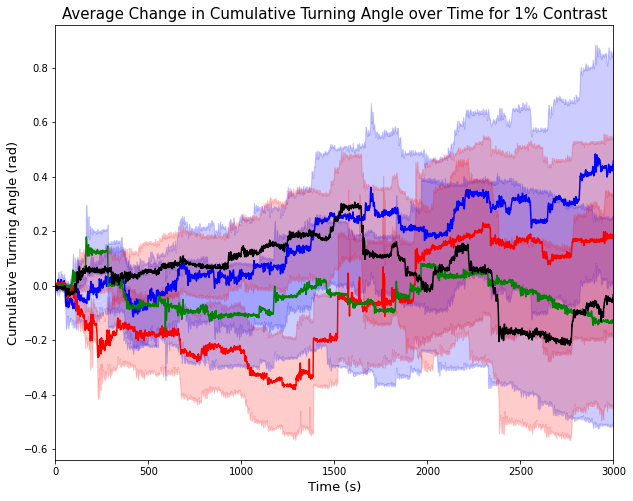

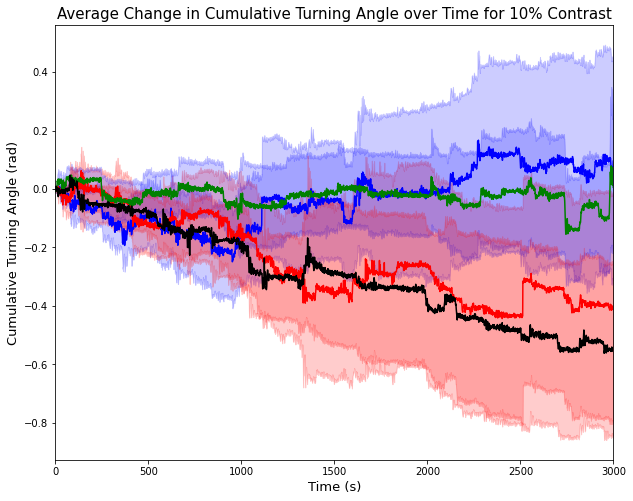

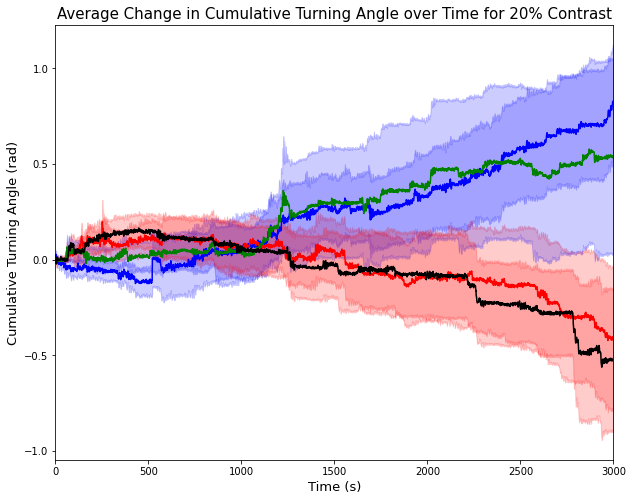

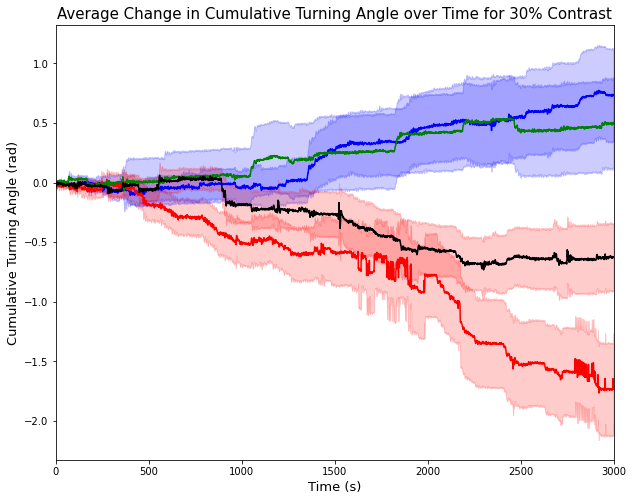

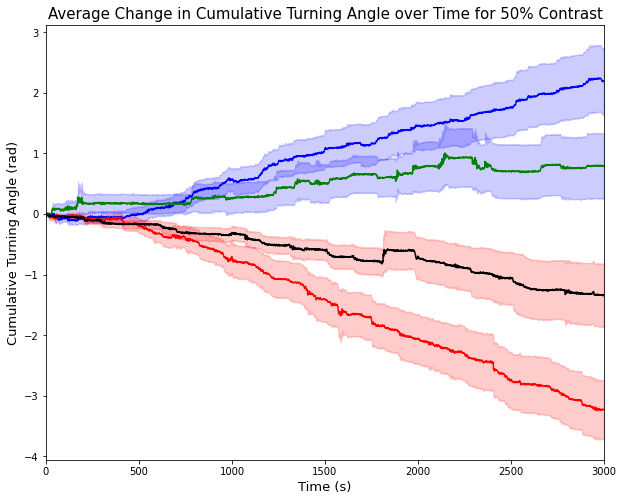

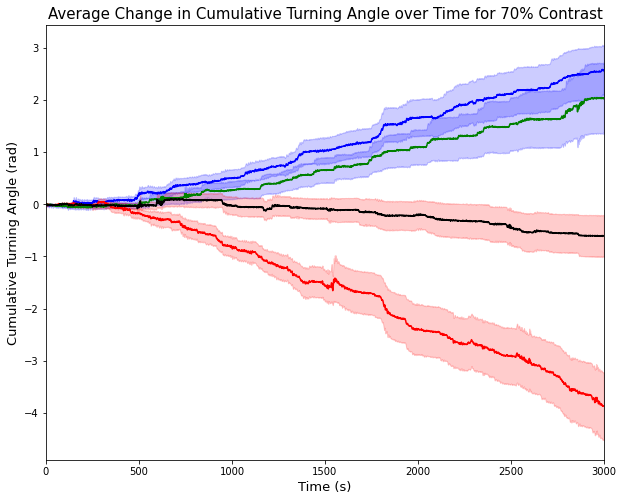

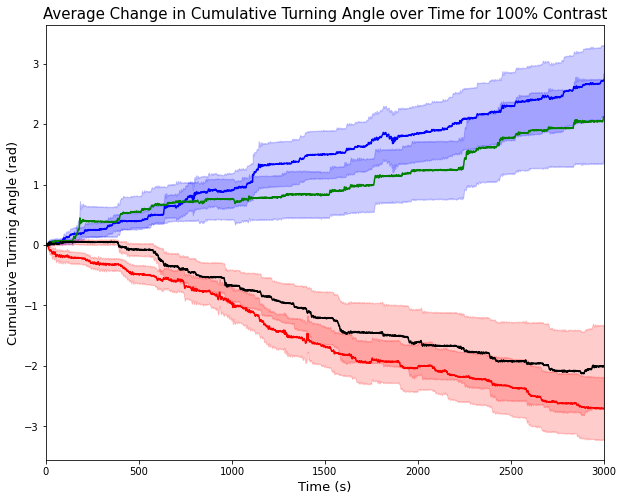

In [11]:
for c in ['1','10','20','30','50','70','100']:
    exec(f'avg_pm_LmeC{c}_trajectory = np.mean(pm_comb_LmeC{c}[:,:,4],axis=0)')
    exec(f'avg_pm_RmeC{c}_trajectory = np.mean(pm_comb_RmeC{c}[:,:,4],axis=0)')

    exec(f'avg_pm_LmeC{c}_SEM = stats.sem(pm_comb_LmeC{c}[:,:,4],axis=0)')
    exec(f'avg_pm_RmeC{c}_SEM = stats.sem(pm_comb_RmeC{c}[:,:,4],axis=0)')
    
    exec(f'avg_am_LmeC{c}_trajectory = np.mean(am_comb_LmeC{c}[:,:,4],axis=0)')
    exec(f'avg_am_RmeC{c}_trajectory = np.mean(am_comb_RmeC{c}[:,:,4],axis=0)')

    exec(f'avg_am_LmeC{c}_SEM = stats.sem(am_comb_LmeC{c}[:,:,4],axis=0)')
    exec(f'avg_am_RmeC{c}_SEM = stats.sem(am_comb_RmeC{c}[:,:,4],axis=0)')

    exec(f'fig, ax = plt.subplots(1,1,figsize=(10,8))')
    exec(f'plt.title("Average Change in Cumulative Turning Angle over Time for {c}% Contrast",fontsize=15)')
    exec(f'ax.set_xlabel("Time (s)",fontsize=13)')
    exec(f'ax.set_ylabel("Cumulative Turning Angle (rad)",fontsize=13)')
    exec(f'ax.set_xlim(0,3000)')
    exec(f'ax.plot(avg_pm_LmeC{c}_trajectory,c="b")')
    exec(f'ax.plot(avg_pm_RmeC{c}_trajectory,c="r")')
    exec(f'ax.plot(avg_am_LmeC{c}_trajectory,c="g")')
    exec(f'ax.plot(avg_am_RmeC{c}_trajectory,c="k")')
    exec(f'ax.fill_between(range(0,3000), avg_pm_LmeC{c}_trajectory-avg_pm_LmeC{c}_SEM, avg_pm_LmeC{c}_trajectory+\
            avg_pm_LmeC{c}_SEM,color="b",alpha=0.2)')
    exec(f'ax.fill_between(range(0,3000), avg_pm_RmeC{c}_trajectory-avg_pm_RmeC{c}_SEM, avg_pm_RmeC{c}_trajectory+\
            avg_pm_RmeC{c}_SEM,color="r",alpha=0.2)')
    exec(f'ax.fill_between(range(0,3000), avg_am_LmeC{c}_trajectory-avg_am_LmeC{c}_SEM, avg_am_LmeC{c}_trajectory+\
            avg_am_LmeC{c}_SEM,color="b",alpha=0.2)')
    exec(f'ax.fill_between(range(0,3000), avg_am_RmeC{c}_trajectory-avg_am_RmeC{c}_SEM, avg_am_RmeC{c}_trajectory+\
            avg_am_RmeC{c}_SEM,color="r",alpha=0.2)')
    exec(f'plt.show()')

# Combining Left and Right Flows

In [12]:
pm_comb_ReC1[:,:,4] = abs(pm_comb_ReC1[:,:,4])
pm_comb_ReC10[:,:,4] = abs(pm_comb_ReC10[:,:,4])
pm_comb_ReC20[:,:,4] = abs(pm_comb_ReC20[:,:,4])
pm_comb_ReC30[:,:,4] = abs(pm_comb_ReC30[:,:,4])
pm_comb_ReC50[:,:,4] = abs(pm_comb_ReC50[:,:,4])
pm_comb_ReC70[:,:,4] = abs(pm_comb_ReC70[:,:,4])
pm_comb_ReC100[:,:,4] = abs(pm_comb_ReC100[:,:,4])

In [13]:
am_comb_ReC1[:,:,4] = abs(am_comb_ReC1[:,:,4])
am_comb_ReC10[:,:,4] = abs(am_comb_ReC10[:,:,4])
am_comb_ReC20[:,:,4] = abs(am_comb_ReC20[:,:,4])
am_comb_ReC30[:,:,4] = abs(am_comb_ReC30[:,:,4])
am_comb_ReC50[:,:,4] = abs(am_comb_ReC50[:,:,4])
am_comb_ReC70[:,:,4] = abs(am_comb_ReC70[:,:,4])
am_comb_ReC100[:,:,4] = abs(am_comb_ReC100[:,:,4])

In [14]:
pm_comb_RmeC1[:,:,4] = abs(pm_comb_RmeC1[:,:,4])
pm_comb_RmeC10[:,:,4] = abs(pm_comb_RmeC10[:,:,4])
pm_comb_RmeC20[:,:,4] = abs(pm_comb_RmeC20[:,:,4])
pm_comb_RmeC30[:,:,4] = abs(pm_comb_RmeC30[:,:,4])
pm_comb_RmeC50[:,:,4] = abs(pm_comb_RmeC50[:,:,4])
pm_comb_RmeC70[:,:,4] = abs(pm_comb_RmeC70[:,:,4])
pm_comb_RmeC100[:,:,4] = abs(pm_comb_RmeC100[:,:,4])

In [15]:
am_comb_RmeC1[:,:,4] = abs(am_comb_RmeC1[:,:,4])
am_comb_RmeC10[:,:,4] = abs(am_comb_RmeC10[:,:,4])
am_comb_RmeC20[:,:,4] = abs(am_comb_RmeC20[:,:,4])
am_comb_RmeC30[:,:,4] = abs(am_comb_RmeC30[:,:,4])
am_comb_RmeC50[:,:,4] = abs(am_comb_RmeC50[:,:,4])
am_comb_RmeC70[:,:,4] = abs(am_comb_RmeC70[:,:,4])
am_comb_RmeC100[:,:,4] = abs(am_comb_RmeC100[:,:,4])

In [16]:
pm_eC1 = np.vstack((pm_comb_LeC1,pm_comb_ReC1))
pm_eC10 = np.vstack((pm_comb_LeC10,pm_comb_ReC10))
pm_eC20 = np.vstack((pm_comb_LeC20,pm_comb_ReC20))
pm_eC30 = np.vstack((pm_comb_LeC30,pm_comb_ReC30))
pm_eC50 = np.vstack((pm_comb_LeC50,pm_comb_ReC50))
pm_eC70 = np.vstack((pm_comb_LeC70,pm_comb_ReC70))
pm_eC100 = np.vstack((pm_comb_LeC100,pm_comb_ReC100))

In [17]:
am_eC1 = np.vstack((am_comb_LeC1,am_comb_ReC1))
am_eC10 = np.vstack((am_comb_LeC10,am_comb_ReC10))
am_eC20 = np.vstack((am_comb_LeC20,am_comb_ReC20))
am_eC30 = np.vstack((am_comb_LeC30,am_comb_ReC30))
am_eC50 = np.vstack((am_comb_LeC50,am_comb_ReC50))
am_eC70 = np.vstack((am_comb_LeC70,am_comb_ReC70))
am_eC100 = np.vstack((am_comb_LeC100,am_comb_ReC100))

In [18]:
pm_meC1 = np.vstack((pm_comb_LmeC1,pm_comb_RmeC1))
pm_meC10 = np.vstack((pm_comb_LmeC10,pm_comb_RmeC10))
pm_meC20 = np.vstack((pm_comb_LmeC20,pm_comb_RmeC20))
pm_meC30 = np.vstack((pm_comb_LmeC30,pm_comb_RmeC30))
pm_meC50 = np.vstack((pm_comb_LmeC50,pm_comb_RmeC50))
pm_meC70 = np.vstack((pm_comb_LmeC70,pm_comb_RmeC70))
pm_meC100 = np.vstack((pm_comb_LmeC100,pm_comb_RmeC100))

In [19]:
am_meC1 = np.vstack((am_comb_LmeC1,am_comb_RmeC1))
am_meC10 = np.vstack((am_comb_LmeC10,am_comb_RmeC10))
am_meC20 = np.vstack((am_comb_LmeC20,am_comb_RmeC20))
am_meC30 = np.vstack((am_comb_LmeC30,am_comb_RmeC30))
am_meC50 = np.vstack((am_comb_LmeC50,am_comb_RmeC50))
am_meC70 = np.vstack((am_comb_LmeC70,am_comb_RmeC70))
am_meC100 = np.vstack((am_comb_LmeC100,am_comb_RmeC100))

# Saving Stacked Data as csv

In [20]:
# pd.DataFrame(pm_eC1.copy().reshape(pm_eC1.shape[0]*pm_eC1.shape[1],-1)).to_csv('../raw_data/pm_eC1.csv')
# pd.DataFrame(pm_eC10.copy().reshape(pm_eC10.shape[0]*pm_eC10.shape[1],-1)).to_csv('../raw_data/pm_eC10.csv')
# pd.DataFrame(pm_eC20.copy().reshape(pm_eC20.shape[0]*pm_eC20.shape[1],-1)).to_csv('../raw_data/pm_eC20.csv')
# pd.DataFrame(pm_eC30.copy().reshape(pm_eC30.shape[0]*pm_eC30.shape[1],-1)).to_csv('../raw_data/pm_eC30.csv')
# pd.DataFrame(pm_eC50.copy().reshape(pm_eC50.shape[0]*pm_eC50.shape[1],-1)).to_csv('../raw_data/pm_eC50.csv')
# pd.DataFrame(pm_eC70.copy().reshape(pm_eC70.shape[0]*pm_eC70.shape[1],-1)).to_csv('../raw_data/pm_eC70.csv')
# pd.DataFrame(pm_eC100.copy().reshape(pm_eC100.shape[0]*pm_eC100.shape[1],-1)).to_csv('../raw_data/pm_eC100.csv')

In [21]:
# pd.DataFrame(pm_meC1.copy().reshape(pm_meC1.shape[0]*pm_meC1.shape[1],-1)).to_csv('../raw_data/pm_meC1.csv')
# pd.DataFrame(pm_meC10.copy().reshape(pm_meC10.shape[0]*pm_meC10.shape[1],-1)).to_csv('../raw_data/pm_meC10.csv')
# pd.DataFrame(pm_meC20.copy().reshape(pm_meC20.shape[0]*pm_meC20.shape[1],-1)).to_csv('../raw_data/pm_meC20.csv')
# pd.DataFrame(pm_meC30.copy().reshape(pm_meC30.shape[0]*pm_meC30.shape[1],-1)).to_csv('../raw_data/pm_meC30.csv')
# pd.DataFrame(pm_meC50.copy().reshape(pm_meC50.shape[0]*pm_meC50.shape[1],-1)).to_csv('../raw_data/pm_meC50.csv')
# pd.DataFrame(pm_meC70.copy().reshape(pm_meC70.shape[0]*pm_meC70.shape[1],-1)).to_csv('../raw_data/pm_meC70.csv')
# pd.DataFrame(pm_meC100.copy().reshape(pm_meC100.shape[0]*pm_meC100.shape[1],-1)).to_csv('../raw_data/pm_meC100.csv')

In [22]:
# pd.DataFrame(am_eC1.copy().reshape(am_eC1.shape[0]*am_eC1.shape[1],-1)).to_csv('../raw_data/am_eC1.csv')
# pd.DataFrame(am_eC10.copy().reshape(am_eC10.shape[0]*am_eC10.shape[1],-1)).to_csv('../raw_data/am_eC10.csv')
# pd.DataFrame(am_eC20.copy().reshape(am_eC20.shape[0]*am_eC20.shape[1],-1)).to_csv('../raw_data/am_eC20.csv')
# pd.DataFrame(am_eC30.copy().reshape(am_eC30.shape[0]*am_eC30.shape[1],-1)).to_csv('../raw_data/am_eC30.csv')
# pd.DataFrame(am_eC50.copy().reshape(am_eC50.shape[0]*am_eC50.shape[1],-1)).to_csv('../raw_data/am_eC50.csv')
# pd.DataFrame(am_eC70.copy().reshape(am_eC70.shape[0]*am_eC70.shape[1],-1)).to_csv('../raw_data/am_eC70.csv')
# pd.DataFrame(am_eC100.copy().reshape(am_eC100.shape[0]*am_eC100.shape[1],-1)).to_csv('../raw_data/am_eC100.csv')

In [23]:
# pd.DataFrame(am_meC1.copy().reshape(am_meC1.shape[0]*am_meC1.shape[1],-1)).to_csv('../raw_data/am_meC1.csv')
# pd.DataFrame(am_meC10.copy().reshape(am_meC10.shape[0]*am_meC10.shape[1],-1)).to_csv('../raw_data/am_meC10.csv')
# pd.DataFrame(am_meC20.copy().reshape(am_meC20.shape[0]*am_meC20.shape[1],-1)).to_csv('../raw_data/am_meC20.csv')
# pd.DataFrame(am_meC30.copy().reshape(am_meC30.shape[0]*am_meC30.shape[1],-1)).to_csv('../raw_data/am_meC30.csv')
# pd.DataFrame(am_meC50.copy().reshape(am_meC50.shape[0]*am_meC50.shape[1],-1)).to_csv('../raw_data/am_meC50.csv')
# pd.DataFrame(am_meC70.copy().reshape(am_meC70.shape[0]*am_meC70.shape[1],-1)).to_csv('../raw_data/am_meC70.csv')
# pd.DataFrame(am_meC100.copy().reshape(am_meC100.shape[0]*am_meC100.shape[1],-1)).to_csv('../raw_data/am_meC100.csv')

# Calculation of Mean and SEM of Cumulative Angles

In [24]:
pm_eC1_cum = pm_eC1[:,-1,4]
pm_eC10_cum = pm_eC10[:,-1,4]
pm_eC20_cum = pm_eC20[:,-1,4]
pm_eC30_cum = pm_eC30[:,-1,4]
pm_eC50_cum = pm_eC50[:,-1,4]
pm_eC70_cum = pm_eC70[:,-1,4]
pm_eC100_cum = pm_eC100[:,-1,4]

In [25]:
am_eC1_cum = am_eC1[:,-1,4]
am_eC10_cum = am_eC10[:,-1,4]
am_eC20_cum = am_eC20[:,-1,4]
am_eC30_cum = am_eC30[:,-1,4]
am_eC50_cum = am_eC50[:,-1,4]
am_eC70_cum = am_eC70[:,-1,4]
am_eC100_cum = am_eC100[:,-1,4]

In [26]:
pm_meC1_cum = pm_meC1[:,-1,4]
pm_meC10_cum = pm_meC10[:,-1,4]
pm_meC20_cum = pm_meC20[:,-1,4]
pm_meC30_cum = pm_meC30[:,-1,4]
pm_meC50_cum = pm_meC50[:,-1,4]
pm_meC70_cum = pm_meC70[:,-1,4]
pm_meC100_cum = pm_meC100[:,-1,4]

In [27]:
am_meC1_cum = am_meC1[:,-1,4]
am_meC10_cum = am_meC10[:,-1,4]
am_meC20_cum = am_meC20[:,-1,4]
am_meC30_cum = am_meC30[:,-1,4]
am_meC50_cum = am_meC50[:,-1,4]
am_meC70_cum = am_meC70[:,-1,4]
am_meC100_cum = am_meC100[:,-1,4]

In [28]:
pm_eC1_sem = stats.sem(pm_eC1[:,-1,4])
pm_eC10_sem = stats.sem(pm_eC10[:,-1,4])
pm_eC20_sem = stats.sem(pm_eC20[:,-1,4])
pm_eC30_sem = stats.sem(pm_eC30[:,-1,4])
pm_eC50_sem = stats.sem(pm_eC50[:,-1,4])
pm_eC70_sem = stats.sem(pm_eC70[:,-1,4])
pm_eC100_sem = stats.sem(pm_eC100[:,-1,4])

In [29]:
am_eC1_sem = stats.sem(am_eC1[:,-1,4])
am_eC10_sem = stats.sem(am_eC10[:,-1,4])
am_eC20_sem = stats.sem(am_eC20[:,-1,4])
am_eC30_sem = stats.sem(am_eC30[:,-1,4])
am_eC50_sem = stats.sem(am_eC50[:,-1,4])
am_eC70_sem = stats.sem(am_eC70[:,-1,4])
am_eC100_sem = stats.sem(am_eC100[:,-1,4])

In [30]:
pm_meC1_sem = stats.sem(pm_meC1[:,-1,4])
pm_meC10_sem = stats.sem(pm_meC10[:,-1,4])
pm_meC20_sem = stats.sem(pm_meC20[:,-1,4])
pm_meC30_sem = stats.sem(pm_meC30[:,-1,4])
pm_meC50_sem = stats.sem(pm_meC50[:,-1,4])
pm_meC70_sem = stats.sem(pm_meC70[:,-1,4])
pm_meC100_sem = stats.sem(pm_meC100[:,-1,4])

In [31]:
am_meC1_sem = stats.sem(am_meC1[:,-1,4])
am_meC10_sem = stats.sem(am_meC10[:,-1,4])
am_meC20_sem = stats.sem(am_meC20[:,-1,4])
am_meC30_sem = stats.sem(am_meC30[:,-1,4])
am_meC50_sem = stats.sem(am_meC50[:,-1,4])
am_meC70_sem = stats.sem(am_meC70[:,-1,4])
am_meC100_sem = stats.sem(am_meC100[:,-1,4])

In [32]:
x = [1,10,20,30,50,70,100]
pm_e_yerr = [pm_eC1_sem,pm_eC10_sem,pm_eC20_sem,pm_eC30_sem,pm_eC50_sem,pm_eC70_sem,pm_eC100_sem]
pm_me_yerr = [pm_meC1_sem,pm_meC10_sem,pm_meC20_sem,pm_meC30_sem,pm_meC50_sem,pm_meC70_sem,pm_meC100_sem]
am_e_yerr = [am_eC1_sem,am_eC10_sem,am_eC20_sem,am_eC30_sem,am_eC50_sem,am_eC70_sem,am_eC100_sem]
am_me_yerr = [am_meC1_sem,am_meC10_sem,am_meC20_sem,am_meC30_sem,am_meC50_sem,am_meC70_sem,am_meC100_sem]

pm_e_cum = [np.mean(pm_eC1_cum),np.mean(pm_eC10_cum),np.mean(pm_eC20_cum),np.mean(pm_eC30_cum),\
                                 np.mean(pm_eC50_cum),np.mean(pm_eC70_cum),np.mean(pm_eC100_cum)]
pm_me_cum = [np.mean(pm_meC1_cum),np.mean(pm_meC10_cum),np.mean(pm_meC20_cum),np.mean(pm_meC30_cum),\
                                 np.mean(pm_meC50_cum),np.mean(pm_meC70_cum),np.mean(pm_meC100_cum)]

am_e_cum = [np.mean(am_eC1_cum),np.mean(am_eC10_cum),np.mean(am_eC20_cum),np.mean(am_eC30_cum),\
                                 np.mean(am_eC50_cum),np.mean(am_eC70_cum),np.mean(am_eC100_cum)]
am_me_cum = [np.mean(am_meC1_cum),np.mean(am_meC10_cum),np.mean(am_meC20_cum),np.mean(am_meC30_cum),\
                                 np.mean(am_meC50_cum),np.mean(am_meC70_cum),np.mean(am_meC100_cum)]

# Fitting Sigmoid Curve

/var/folders/wd/4w68b8ld47x6kzpx1zhzn8qm0000gn/T/ipykernel_10248/2780036809.py:2: RuntimeWarning: overflow encountered in exp
  y = L / (1 + np.exp(-k*(x-x0)))+b


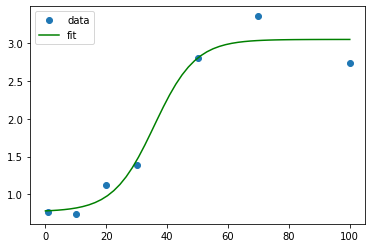

In [33]:
def sigmoid(x, L ,x0, k, b):
    y = L / (1 + np.exp(-k*(x-x0)))+b
    return (y)

xdata = [1,10,20,30,50,70,100]
ydata = pm_me_cum

p0 = [max(ydata), np.median(xdata),1,min(ydata)] # this is an mandatory initial guess

popt, pcov = curve_fit(sigmoid, xdata, ydata,p0, method='dogbox')

y = sigmoid(xdata, *popt)
new_x = np.linspace(0,100,50)
new_y = sigmoid(new_x, *popt)
plt.plot(xdata, ydata, 'o', label='data')
plt.plot(new_x,new_y,'g-',label='fit')
plt.legend()

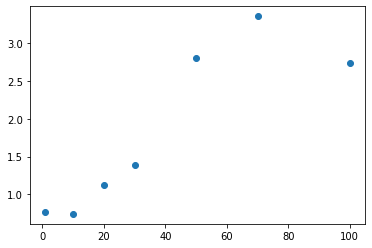

In [34]:
plt.plot(xdata,ydata,'o')

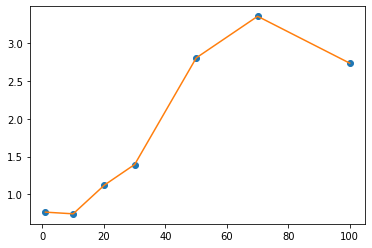

In [35]:
x = [1,10,20,30,50,70,100]
y = pm_me_cum
f = interpolate.interp1d(x, y)
xnew = np.arange(1, 100, 0.01)
ynew = f(xnew)   # use interpolation function returned by `interp1d`
plt.plot(x, y, 'o', xnew, ynew, '-')
plt.show()

In [36]:
def sigmoid(x, L ,x0, k, b):
    y = L / (1 + np.exp(-k*(x-x0)))+b
    return (y)

# xdata = [1,10,20,30,50,70,100]
# ydata = pm_me_cum

def fit_sigmoid(ydata):
    xdata = [1,10,20,30,50,70,100]
    p0 = [max(ydata), np.median(xdata),1,min(ydata)] # this is an mandatory initial guess
    popt, pcov = curve_fit(sigmoid, xdata, ydata,p0, method='dogbox')
    y = sigmoid(xdata, *popt)
    new_x = np.linspace(0,100,50)
    new_y = sigmoid(new_x, *popt)
    return new_y

In [37]:
pm_e_cum_fit = fit_sigmoid(pm_e_cum)
pm_me_cum_fit = fit_sigmoid(pm_me_cum)

am_e_cum_fit = fit_sigmoid(am_e_cum)
am_me_cum_fit = fit_sigmoid(am_me_cum)

/var/folders/wd/4w68b8ld47x6kzpx1zhzn8qm0000gn/T/ipykernel_10248/594421320.py:2: RuntimeWarning: overflow encountered in exp
  y = L / (1 + np.exp(-k*(x-x0)))+b


# Contrast Response Plot

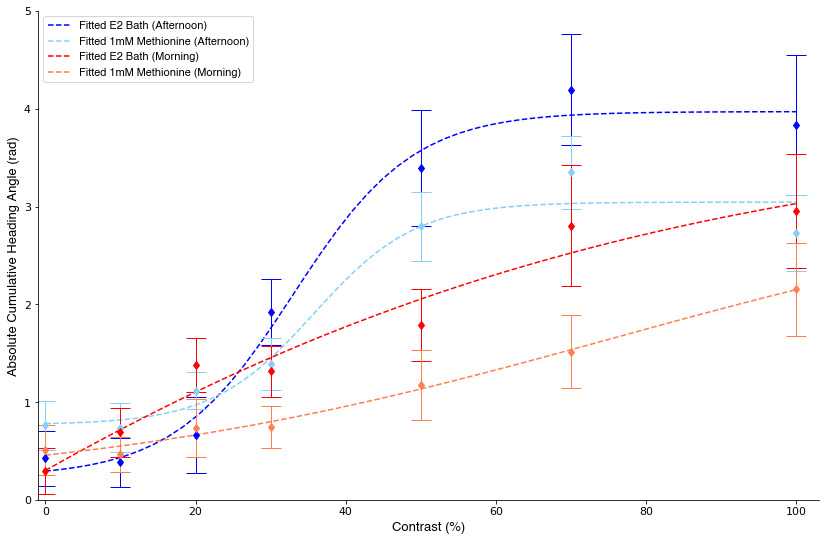

In [225]:
fig, ax = plt.subplots(1,1,figsize=(14,9))

# ax.plot(x,pm_e_cum,c='b',marker='d',mfc='b',label='E2 Bath (Afternoon)')
ax.plot(np.linspace(0,100,50),pm_e_cum_fit,'--b',label='Fitted E2 Bath (Afternoon)')
# ax.plot(x,pm_me_cum,c='lightskyblue',marker='d',mfc='lightskyblue',label='1mM Methionine (Afternoon)')
ax.plot(np.linspace(0,100,50),pm_me_cum_fit,c='lightskyblue',ls='--',label='Fitted 1mM Methionine (Afternoon)')
ax.errorbar(x,pm_e_cum,yerr=pm_e_yerr,fmt='d',color='b',capsize=10,elinewidth=1)
ax.errorbar(x,pm_me_cum,yerr=pm_me_yerr,fmt='d',color='lightskyblue',capsize=10,elinewidth=1)


# ax.plot(x,am_e_cum,c='r',marker='d',mfc='r',label='E2 Bath (Morning)')
ax.plot(np.linspace(0,100,50),am_e_cum_fit,'--r',label='Fitted E2 Bath (Morning)')
# ax.plot(x,am_me_cum,c='coral',marker='d',mfc='coral',label='1mM Methionine (Morning)')
ax.plot(np.linspace(0,100,50),am_me_cum_fit,c='coral',ls='--',label='Fitted 1mM Methionine (Morning)')
ax.errorbar(x,am_e_cum,yerr=am_e_yerr,fmt='d',color='r',capsize=10,elinewidth=1)
ax.errorbar(x,am_me_cum,yerr=am_me_yerr,fmt='d',color='coral',capsize=10,elinewidth=1)


font = font_manager.FontProperties(family='Helvetica',
                                   style='normal', size=11)
plt.legend(loc='upper left',prop=font)
plt.title('')
plt.xlabel('Contrast (%)',size=13,name='Helvetica')
plt.ylabel('Absolute Cumulative Heading Angle (rad)',size=13,name='Helvetica')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# plt.grid(which='major',axis='y')
# x_ticks = [1, 10, 20, 30, 50, 70, 100]
# x_labels = [1, 10, 20, 30, 50, 70, 100] 
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
ax.set_ylim(0,5)
ax.set_xlim(-1,103)
# plt.savefig('../../Dissertation/contrast_function.png',dpi=400,bbox_inches='tight')
plt.show()

# ANOVA DataFrames for Cumulative Angles

In [39]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [40]:
for m in ['e','me']:
    for t in ['pm','am']:
        for c in ['1','10','20','30','50','70','100']:
            exec(f"anova_df_{m}_{t}_{c} = pd.DataFrame(columns=['medium','time','contrast','final_cum_angle'])")
            exec(f"anova_df_{m}_{t}_{c}['final_cum_angle'] = {t}_{m}C{c}_cum")
            exec(f"anova_df_{m}_{t}_{c}['medium'] = '{m}'")
            exec(f"anova_df_{m}_{t}_{c}['time'] = '{t}'")
            exec(f"anova_df_{m}_{t}_{c}['contrast'] = {c}")

In [42]:
anova_df = pd.DataFrame(columns=['medium','time','contrast','final_cum_angle'])
anova_df = pd.concat([anova_df_e_am_1,anova_df_e_am_10,anova_df_e_am_20,anova_df_e_am_30,anova_df_e_am_50,\
                    anova_df_e_am_70,anova_df_e_am_100,\
                    anova_df_e_pm_1,anova_df_e_pm_10,anova_df_e_pm_20,anova_df_e_pm_30,anova_df_e_pm_50,\
                    anova_df_e_pm_70,anova_df_e_pm_100,\
                    anova_df_me_am_1,anova_df_me_am_10,anova_df_me_am_20,anova_df_me_am_30,anova_df_me_am_50,\
                    anova_df_me_am_70,anova_df_me_am_100,\
                    anova_df_me_pm_1,anova_df_me_pm_10,anova_df_me_pm_20,anova_df_me_pm_30,anova_df_me_pm_50,\
                    anova_df_me_pm_70,anova_df_me_pm_100])

In [43]:
anova_df_am = anova_df[anova_df['time']=='am']
anova_df_pm = anova_df[anova_df['time']=='pm']

In [41]:
# anova_df.to_csv('../raw_data/anova_df.csv')

In [44]:
anova_df = anova_df.reset_index()
anova_df = anova_df.drop(columns='index')

# Levene Test and Welch ANOVA for Cumulative Angles

In [134]:
stats.levene(anova_df_e_am_1['final_cum_angle'],anova_df_e_am_10['final_cum_angle'],\
             anova_df_e_am_20['final_cum_angle'],anova_df_e_am_30['final_cum_angle'],\
             anova_df_e_am_50['final_cum_angle'],anova_df_e_am_70['final_cum_angle'],\
             anova_df_e_am_100['final_cum_angle'],anova_df_e_pm_1['final_cum_angle'],\
             anova_df_e_pm_10['final_cum_angle'],anova_df_e_pm_20['final_cum_angle'],\
             anova_df_e_pm_30['final_cum_angle'],anova_df_e_pm_50['final_cum_angle'],\
             anova_df_e_pm_70['final_cum_angle'],anova_df_e_pm_100['final_cum_angle'],\
             anova_df_me_am_1['final_cum_angle'],anova_df_me_am_10['final_cum_angle'],\
             anova_df_me_am_20['final_cum_angle'],anova_df_me_am_30['final_cum_angle'],\
             anova_df_me_am_50['final_cum_angle'],anova_df_me_am_70['final_cum_angle'],\
             anova_df_me_am_100['final_cum_angle'],anova_df_me_pm_1['final_cum_angle'],\
             anova_df_me_pm_10['final_cum_angle'],anova_df_me_pm_20['final_cum_angle'],\
             anova_df_me_pm_30['final_cum_angle'],anova_df_me_pm_50['final_cum_angle'],\
             anova_df_me_pm_70['final_cum_angle'],anova_df_me_pm_100['final_cum_angle'])

LeveneResult(statistic=5.89956129735749, pvalue=7.479976453130293e-19)

In [ ]:
stats.alexandergovern()

In [ ]:
stats.kruskal()

In [151]:
pg.welch_anova(data=anova_df,dv='final_cum_angle',between='time')

,Source,ddof1,ddof2,F,p-unc,np2
0,time,1,968.562584,19.001426,0.000014,0.018425


In [147]:
pg.welch_anova(data=anova_df_am,dv='final_cum_angle',between='medium')

,Source,ddof1,ddof2,F,p-unc,np2
0,medium,1,398.435823,7.720179,0.005719,0.017744


In [148]:
pg.welch_anova(data=anova_df_pm,dv='final_cum_angle',between='medium')

,Source,ddof1,ddof2,F,p-unc,np2
0,medium,1,401.4085,1.31457,0.252252,0.002679


In [149]:
pg.welch_anova(data=anova_df_am,dv='final_cum_angle',between='contrast')

,Source,ddof1,ddof2,F,p-unc,np2
0,contrast,6,188.559882,8.079,8.923863e-08,0.119713


In [150]:
pg.welch_anova(data=anova_df_pm,dv='final_cum_angle',between='contrast')

,Source,ddof1,ddof2,F,p-unc,np2
0,contrast,6,232.933988,23.69193,8.224519e-22,0.218348


#  Cumulative Angles OLS & ANOVA

In [45]:
model = ols(formula='final_cum_angle ~ C(medium, Sum) + C(time, Sum) + C(contrast, Sum) + C(medium, Sum):\
                        C(time, Sum) + C(medium, Sum):C(contrast, Sum) + C(time, Sum):C(contrast, Sum) + \
                        C(medium, Sum):C(time, Sum):C(contrast, Sum)',data=anova_df).fit()
anova_table = sm.stats.anova_lm(model, typ=3)
anova_table

,sum_sq,df,F,PR(>F)
Intercept,2603.831076,1.0,535.065752,4.037051e-94
"C(medium, Sum)",41.528042,1.0,8.533669,3.569492e-03
"C(time, Sum)",102.194107,1.0,21.000044,5.209601e-06
"C(contrast, Sum)",925.161304,6.0,31.685499,7.938270e-35
"C(medium, Sum):C(time, Sum)",4.875912,1.0,1.001960,3.170936e-01
"C(medium, Sum):C(contrast, Sum)",53.742682,6.0,1.840613,8.829126e-02
"C(time, Sum):C(contrast, Sum)",107.918752,6.0,3.696069,1.228153e-03
"C(medium, Sum):C(time, Sum):C(contrast, Sum)",10.851999,6.0,0.371666,8.971646e-01
Residual,4588.992471,943.0,NaN,NaN


In [112]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        final_cum_angle   R-squared:                       0.218
Model:                            OLS   Adj. R-squared:                  0.196
Method:                 Least Squares   F-statistic:                     9.749
Date:                Sat, 23 Apr 2022   Prob (F-statistic):           4.25e-35
Time:                        07:28:01   Log-Likelihood:                -2131.8
No. Observations:                 971   AIC:                             4320.
Df Residuals:                     943   BIC:                             4456.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
=================================================================================================================================
                                                                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------
Intercept                                                         1.6533      0.071     23.131      0.000       1.513       1.794
C(medium, Sum)[S.e]                                               0.2088      0.071      2.921      0.004       0.069       0.349
C(time, Sum)[S.am]                                               -0.3275      0.071     -4.583      0.000      -0.468      -0.187
C(contrast, Sum)[S.1]                                            -1.1529      0.175     -6.586      0.000      -1.496      -0.809
C(contrast, Sum)[S.10]                                           -1.0805      0.174     -6.218      0.000      -1.422      -0.739
C(contrast, Sum)[S.20]                                           -0.6778      0.175     -3.877      0.000      -1.021      -0.335
C(contrast, Sum)[S.30]                                           -0.3080      0.175     -1.760      0.079      -0.651       0.035
C(contrast, Sum)[S.50]                                            0.6383      0.176      3.619      0.000       0.292       0.985
C(contrast, Sum)[S.70]                                            1.3141      0.176      7.480      0.000       0.969       1.659
C(medium, Sum)[S.e]:C(time, Sum)[S.am]                            0.0715      0.071      1.001      0.317      -0.069       0.212
C(medium, Sum)[S.e]:C(contrast, Sum)[S.1]                        -0.3463      0.175     -1.978      0.048      -0.690      -0.003
C(medium, Sum)[S.e]:C(contrast, Sum)[S.10]                       -0.2419      0.174     -1.392      0.164      -0.583       0.099
C(medium, Sum)[S.e]:C(contrast, Sum)[S.20]                       -0.1623      0.175     -0.928      0.353      -0.505       0.181
C(medium, Sum)[S.e]:C(contrast, Sum)[S.30]                        0.0659      0.175      0.376      0.707      -0.278       0.409
C(medium, Sum)[S.e]:C(contrast, Sum)[S.50]                        0.0930      0.176      0.527      0.598      -0.253       0.439
C(medium, Sum)[S.e]:C(contrast, Sum)[S.70]                        0.3244      0.176      1.846      0.065      -0.020       0.669
C(time, Sum)[S.am]:C(contrast, Sum)[S.1]                          0.2314      0.175      1.322      0.186      -0.112       0.575
C(time, Sum)[S.am]:C(contrast, Sum)[S.10]                         0.3357      0.174      1.932      0.054      -0.005       0.677
C(time, Sum)[S.am]:C(contrast, Sum)[S.20]                         0.4123      0.175      2.359      0.019       0.069       0.755
C(time, Sum)[S.am]:C(contrast, Sum)[S.30]                         0.0146      0.175      0.083      0.934      -0.329       0.358
C(time, Sum)[S.am]:C(contrast, Sum)[S.50]                        -0.4791      0.176     -2.71

In [47]:
model_am = ols(formula='final_cum_angle ~ C(medium,Sum) + C(contrast, Sum) + \
                        C(medium,Sum):C(contrast, Sum)',data=anova_df_am).fit()
anova_table_am = sm.stats.anova_lm(model_am, typ=3)
anova_table_am

,sum_sq,df,F,PR(>F)
Intercept,765.810303,1.0,191.477877,3.478512e-36
"C(medium, Sum)",34.241221,1.0,8.561437,3.618560e-03
"C(contrast, Sum)",238.687539,6.0,9.946628,2.793175e-10
"C(medium, Sum):C(contrast, Sum)",20.371639,6.0,0.848930,5.326995e-01
Residual,1691.776429,423.0,NaN,NaN


In [48]:
model_pm = ols(formula='final_cum_angle ~ C(medium,Sum) + C(contrast, Sum) + \
                        C(medium,Sum):C(contrast, Sum)',data=anova_df_pm).fit()
anova_table_pm = sm.stats.anova_lm(model_pm, typ=3)
anova_table_pm

,sum_sq,df,F,PR(>F)
Intercept,2060.888510,1.0,369.893722,1.164530e-62
"C(medium, Sum)",9.894101,1.0,1.775819,1.832472e-01
"C(contrast, Sum)",856.011118,6.0,25.606523,1.074214e-26
"C(medium, Sum):C(contrast, Sum)",46.601666,6.0,1.394032,2.149457e-01
Residual,2897.216042,520.0,NaN,NaN


In [49]:
# pm_eC1.shape

In [50]:
# pm_eC1[1].shape

# Event Table Function

In [51]:
def make_event_table(contrast): 
    fish_distance = contrast[:,-1]
    if np.sum(np.isnan(fish_distance)) > 0:
        np.nan_to_num(fish_distance,copy=False,nan=0)
    t = np.arange(0, 3000, 1)
    sig = fish_distance #composite signal
    sig_clean = sig #copy for later comparison
    minsignal, maxsignal = sig.min(), sig.max()
    widths = np.arange(1, 3000)
    cwtmatr = signal.cwt(sig, signal.ricker, widths)
    t = np.arange(0, 3000, 1)
    cwt_sig = cwtmatr[25,:] #composite signal
    signal_clean = sig #copy for later comparison
    minsignal, maxsignal = cwt_sig.min(), cwt_sig.max()
    ## Compute Fourier Transform
    n = len(t)
    fhat = np.fft.fft(cwt_sig, n) #computes the fft
    psd = fhat * np.conj(fhat)/n
    freq = (1/(1*n)) * np.arange(n) #frequency array
    idxs_half = np.arange(1, np.floor(n/2), dtype=np.int32) #first half index
    ## Filter out noise
    threshold = 1
    psd_idxs = psd > threshold #array of 0 and 1
    psd_clean = psd * psd_idxs #zero out all the unnecessary powers
    fhat_clean = psd_idxs * fhat #used to retrieve the signal
    signal_filtered = np.fft.ifft(fhat_clean) #inverse fourier transform
    fft_signal = signal_filtered.real
    fft_gauss = gaussian_filter1d(fft_signal,sigma=5)
    fish_distance_2 = []
    for frame in fft_gauss:
        if frame<=1:
            frame=0
        fish_distance_2.append(frame)
    fft_gauss = fish_distance_2
    
    # fiter out events mid-beginning and mid-end 
    if fft_gauss[0] != 0:
        zero_start = fft_gauss.index(0)
        fft_gauss[:zero_start] = [0]*(zero_start)
    if fft_gauss[-1] != 0:
        end_zero = -(fft_gauss[::-1].index(0))
        fft_gauss[end_zero:] = [0]*(-end_zero) 
    

    indices = []
    for val in fft_gauss:
        if val == 0:
            indices.append(0)
        else:
            indices.append(fft_gauss.index(val))


    df = pd.DataFrame(fft_gauss,columns=['fft_gauss'])
    df['ind'] = indices
    df['init_cum'] = contrast[:,4]
    df['init_dist'] = contrast[:,5]
    df['event'] = 0


    counter = 1 
    for index, row in df.iterrows():  
        if row['fft_gauss'] != 0:
            df.at[index,'event'] = counter
            if df.at[index+1,'fft_gauss'] == 0:
                counter += 1


    event_df = pd.DataFrame(columns=['event','duration_s','delta_theta_rad','distance','start_ind','end_ind','latency_s'])
    event_df['event'] = df['event'].unique()[1:]

    event_df['duration_s'] = [((df['event']==event).sum())/100 for event in (df['event']).unique()[1:]]

    event_df['start_ind'] = [int(df[df['event']==event].reset_index().iloc[0][0]) for event in (df['event']).unique()[1:]]
    event_df['end_ind'] = [int(df[df['event']==event].reset_index().iloc[-1][0]) for event in (df['event']).unique()[1:]]

    event_df['delta_theta_rad'] = [df['init_cum'][r['end_ind']]-df['init_cum'][r['start_ind']] \
                                   for i, r in event_df.iterrows()]

    event_df['latency_s'] = [None if i-1 == -1 else (event_df['start_ind'][i]-event_df['end_ind'][i-1])/100 \
                             for i, r in event_df.iterrows()]

    # event_df['distance'] = ADD all frames per event except first one
    event_df['distance'] = [df[df['event']==ev]['init_dist'].sum() - df[df['event']==ev]['init_dist'].reset_index()\
                            ['init_dist'][0] for ev in df['event'].unique()[1:]]

    event_df = event_df.drop(columns=['start_ind','end_ind'])
    
    return event_df




In [54]:
df_names = ['am_e_1','am_e_10','am_e_20','am_e_30','am_e_50','am_e_70','am_e_100','pm_e_1','pm_e_10','pm_e_20',\
         'pm_e_30','pm_e_50','pm_e_70','pm_e_100','am_me_1','am_me_10','am_me_20','am_me_30','am_me_50','am_me_70',\
         'am_me_100','pm_me_1','pm_me_10','pm_me_20','pm_me_30','pm_me_50','pm_me_70','pm_me_100']

In [55]:
dataframes = [am_eC1,am_eC10,am_eC20,am_eC30,am_eC50,am_eC70,am_eC100,pm_eC1,pm_eC10,pm_eC20,pm_eC30,pm_eC50,pm_eC70,\
             pm_eC100,am_meC1,am_meC10,am_meC20,am_meC30,am_meC50,am_meC70,am_meC100,pm_meC1,pm_meC10,pm_meC20,\
             pm_meC30,pm_meC50,pm_meC70,pm_meC100]

In [56]:
example_var = 'am_e_1'
int(example_var.split('_')[2])

1

In [58]:
# full_event_table = pd.DataFrame(columns=['event_n','fish_n','event','duration_s','delta_theta_rad','distance',\
#                                          'latency_s','time','medium','contrast'])

# fish_counter = 1
# for name,df in zip(df_names,dataframes):
#     for fish in df:
#         event_df = make_event_table(fish)
#         event_df['time'] = name.split('_')[0]
#         event_df['medium'] = name.split('_')[1]
#         event_df['contrast'] = int(name.split('_')[2])
#         event_df['event_n'] = 0
#         event_df['fish_n'] = fish_counter
#         fish_counter += 1
#         full_event_table = pd.concat([full_event_table,event_df])
        
# full_event_table['event_n'] = np.arange(1,len(full_event_table)+1,1)
# full_event_table = full_event_table.set_index('event_n')

# full_event_table

In [ ]:
# full_event_table.to_csv('../raw_data/full_event_table.csv')

In [ ]:
# full_event_table['fish_n'].unique()

# Load Saved Event Table

In [59]:
full_event_table = pd.read_csv('../raw_data/full_event_table.csv')

In [60]:
full_event_table

,event_n,fish_n,event,duration_s,delta_theta_rad,distance,latency_s,time,medium,contrast
0,1,1,1,0.45,0.05916,35.134617,NaN,am,e,1
1,2,1,2,0.38,-0.00784,23.146016,4.77,am,e,1
2,3,1,3,0.33,0.01877,17.633084,5.50,am,e,1
3,4,1,4,0.32,-0.06640,16.577926,3.40,am,e,1
4,5,1,5,0.41,-0.18964,28.985325,3.61,am,e,1
...,...,...,...,...,...,...,...,...,...,...
8193,8194,971,3,0.56,0.28432,68.215395,2.06,pm,me,100
8194,8195,971,4,0.45,0.00388,31.526435,2.29,pm,me,100
8195,8196,971,5,0.48,0.04139,40.623428,2.00,pm,me,100
8196,8197,971,6,0.42,0.05141,26.514048,5.26,pm,me,100


----

In [83]:
full_event_table['delta_theta_rad']=pd.to_numeric(full_event_table['delta_theta_rad'])

# Dividing Event Table into Individual DataFrames

In [61]:
pm_events = full_event_table[full_event_table['time']=='pm']

In [62]:
pm_events['delta_theta_rad']=pd.to_numeric(pm_events['delta_theta_rad'])

/var/folders/wd/4w68b8ld47x6kzpx1zhzn8qm0000gn/T/ipykernel_10248/3661766217.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pm_events['delta_theta_rad']=pd.to_numeric(pm_events['delta_theta_rad'])


In [63]:
pm_e_events = pm_events[pm_events['medium']=='e']

In [64]:
pm_me_events = pm_events[pm_events['medium']=='me']

--------

In [65]:
am_events = full_event_table[full_event_table['time']=='am']

In [66]:
am_events['delta_theta_rad']=pd.to_numeric(am_events['delta_theta_rad'])

/var/folders/wd/4w68b8ld47x6kzpx1zhzn8qm0000gn/T/ipykernel_10248/291521083.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  am_events['delta_theta_rad']=pd.to_numeric(am_events['delta_theta_rad'])


In [67]:
am_e_events = am_events[am_events['medium']=='e']

In [68]:
am_me_events = am_events[am_events['medium']=='me']

-----

In [69]:
am_e_C1_events = am_e_events[am_e_events['contrast']==1]
am_e_C10_events = am_e_events[am_e_events['contrast']==10]
am_e_C20_events = am_e_events[am_e_events['contrast']==20]
am_e_C30_events = am_e_events[am_e_events['contrast']==30]
am_e_C50_events = am_e_events[am_e_events['contrast']==50]
am_e_C70_events = am_e_events[am_e_events['contrast']==70]
am_e_C100_events = am_e_events[am_e_events['contrast']==100]

In [70]:
am_me_C1_events = am_me_events[am_me_events['contrast']==1]
am_me_C10_events = am_me_events[am_me_events['contrast']==10]
am_me_C20_events = am_me_events[am_me_events['contrast']==20]
am_me_C30_events = am_me_events[am_me_events['contrast']==30]
am_me_C50_events = am_me_events[am_me_events['contrast']==50]
am_me_C70_events = am_me_events[am_me_events['contrast']==70]
am_me_C100_events = am_me_events[am_me_events['contrast']==100]

In [71]:
pm_e_C1_events = pm_e_events[pm_e_events['contrast']==1]
pm_e_C10_events = pm_e_events[pm_e_events['contrast']==10]
pm_e_C20_events = pm_e_events[pm_e_events['contrast']==20]
pm_e_C30_events = pm_e_events[pm_e_events['contrast']==30]
pm_e_C50_events = pm_e_events[pm_e_events['contrast']==50]
pm_e_C70_events = pm_e_events[pm_e_events['contrast']==70]
pm_e_C100_events = pm_e_events[pm_e_events['contrast']==100]

In [72]:
pm_me_C1_events = pm_me_events[pm_me_events['contrast']==1]
pm_me_C10_events = pm_me_events[pm_me_events['contrast']==10]
pm_me_C20_events = pm_me_events[pm_me_events['contrast']==20]
pm_me_C30_events = pm_me_events[pm_me_events['contrast']==30]
pm_me_C50_events = pm_me_events[pm_me_events['contrast']==50]
pm_me_C70_events = pm_me_events[pm_me_events['contrast']==70]
pm_me_C100_events = pm_me_events[pm_me_events['contrast']==100]

# Average Turn Angle per Event (delta_theta_rad) Calculations

In [73]:
print(pm_me_C1_events['delta_theta_rad'].mean())
print(pm_me_C10_events['delta_theta_rad'].mean())
print(pm_me_C20_events['delta_theta_rad'].mean())
print(pm_me_C30_events['delta_theta_rad'].mean())
print(pm_me_C50_events['delta_theta_rad'].mean())
print(pm_me_C70_events['delta_theta_rad'].mean())
print(pm_me_C100_events['delta_theta_rad'].mean())

0.049076331208791346
0.05097382737819024
0.068113400954654
0.1250717221860463
0.21101560177383571
0.26099568385650196
0.22523429055137845


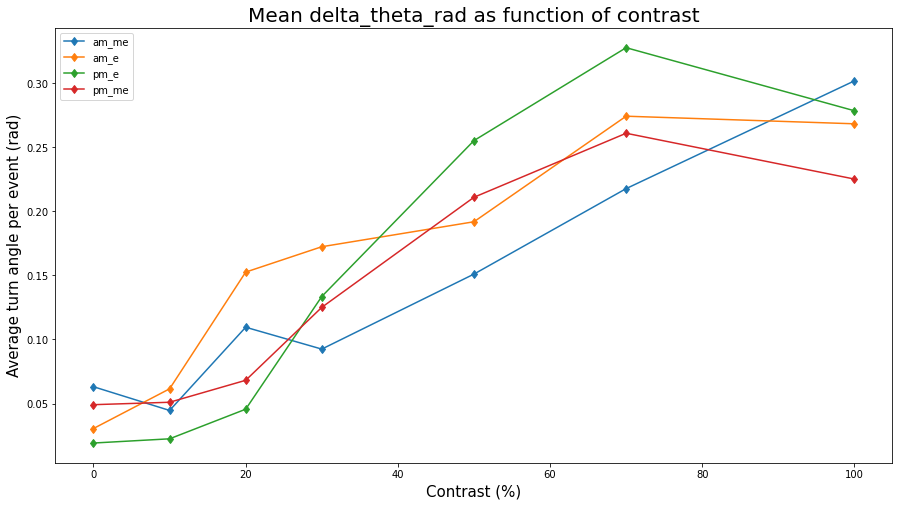

In [74]:
fig, ax = plt.subplots(1,1,figsize=(15,8))
plt.title('Mean delta_theta_rad as function of contrast',size=20)

plt.plot([0,10,20,30,50,70,100],[0.06309584153005456,0.0445759497109824,0.10954774011299466,0.0924750176470586,\
                                 0.15103483236994197,0.21777280245398797,0.301906779263158],'-d',label='am_me')
plt.plot([0,10,20,30,50,70,100],[0.030480077720207326,0.06145861244019116,0.1525926089385474,0.17240031609195386,
                                 0.19190066826923055,0.2743170124034337,0.2683838820422535],'-d',label='am_e')
plt.plot([0,10,20,30,50,70,100],[0.019135225608058394,0.02242735987841947,0.04554144671388122,0.13352862628726303,\
                                 0.2552602469774009,0.3278077182539683,0.27856293714285724],'-d',label='pm_e')
plt.plot([0,10,20,30,50,70,100],[0.04907633120879133,0.05097382737819024,0.06811340095465399,0.12507172218604634,\
                                 0.21101560177383571,0.26099568385650185,0.22523429055137845],'-d',label='pm_me')

plt.xlabel('Contrast (%)',size=15)
plt.ylabel('Average turn angle per event (rad)',size=15)
plt.legend()
plt.show()

In [75]:
am_e_delta = [am_e_C1_events['delta_theta_rad'].mean(),am_e_C10_events['delta_theta_rad'].mean(),\
               am_e_C20_events['delta_theta_rad'].mean(),am_e_C30_events['delta_theta_rad'].mean(),\
               am_e_C50_events['delta_theta_rad'].mean(),am_e_C70_events['delta_theta_rad'].mean(),\
               am_e_C100_events['delta_theta_rad'].mean()]
am_me_delta = [am_me_C1_events['delta_theta_rad'].mean(),am_me_C10_events['delta_theta_rad'].mean(),\
               am_me_C20_events['delta_theta_rad'].mean(),am_me_C30_events['delta_theta_rad'].mean(),\
               am_me_C50_events['delta_theta_rad'].mean(),am_me_C70_events['delta_theta_rad'].mean(),\
               am_me_C100_events['delta_theta_rad'].mean()]
pm_e_delta = [pm_e_C1_events['delta_theta_rad'].mean(),pm_e_C10_events['delta_theta_rad'].mean(),\
               pm_e_C20_events['delta_theta_rad'].mean(),pm_e_C30_events['delta_theta_rad'].mean(),\
               pm_e_C50_events['delta_theta_rad'].mean(),pm_e_C70_events['delta_theta_rad'].mean(),\
               pm_e_C100_events['delta_theta_rad'].mean()]
pm_me_delta = [pm_me_C1_events['delta_theta_rad'].mean(),pm_me_C10_events['delta_theta_rad'].mean(),\
               pm_me_C20_events['delta_theta_rad'].mean(),pm_me_C30_events['delta_theta_rad'].mean(),\
               pm_me_C50_events['delta_theta_rad'].mean(),pm_me_C70_events['delta_theta_rad'].mean(),\
               pm_me_C100_events['delta_theta_rad'].mean()]

In [76]:
am_e_C1_delta_sem = stats.sem(am_e_C1_events['delta_theta_rad'])
am_e_C10_delta_sem = stats.sem(am_e_C10_events['delta_theta_rad'])
am_e_C20_delta_sem = stats.sem(am_e_C20_events['delta_theta_rad'])
am_e_C30_delta_sem = stats.sem(am_e_C30_events['delta_theta_rad'])
am_e_C50_delta_sem = stats.sem(am_e_C50_events['delta_theta_rad'])
am_e_C70_delta_sem = stats.sem(am_e_C70_events['delta_theta_rad'])
am_e_C100_delta_sem = stats.sem(am_e_C100_events['delta_theta_rad'])

In [77]:
am_me_C1_delta_sem = stats.sem(am_e_C1_events['delta_theta_rad'])
am_me_C10_delta_sem = stats.sem(am_e_C10_events['delta_theta_rad'])
am_me_C20_delta_sem = stats.sem(am_e_C20_events['delta_theta_rad'])
am_me_C30_delta_sem = stats.sem(am_e_C30_events['delta_theta_rad'])
am_me_C50_delta_sem = stats.sem(am_e_C50_events['delta_theta_rad'])
am_me_C70_delta_sem = stats.sem(am_e_C70_events['delta_theta_rad'])
am_me_C100_delta_sem = stats.sem(am_e_C100_events['delta_theta_rad'])

In [78]:
pm_e_C1_delta_sem = stats.sem(pm_e_C1_events['delta_theta_rad'])
pm_e_C10_delta_sem = stats.sem(pm_e_C10_events['delta_theta_rad'])
pm_e_C20_delta_sem = stats.sem(pm_e_C20_events['delta_theta_rad'])
pm_e_C30_delta_sem = stats.sem(pm_e_C30_events['delta_theta_rad'])
pm_e_C50_delta_sem = stats.sem(pm_e_C50_events['delta_theta_rad'])
pm_e_C70_delta_sem = stats.sem(pm_e_C70_events['delta_theta_rad'])
pm_e_C100_delta_sem = stats.sem(pm_e_C100_events['delta_theta_rad'])

In [79]:
pm_me_C1_delta_sem = stats.sem(pm_me_C1_events['delta_theta_rad'])
pm_me_C10_delta_sem = stats.sem(pm_me_C10_events['delta_theta_rad'])
pm_me_C20_delta_sem = stats.sem(pm_me_C20_events['delta_theta_rad'])
pm_me_C30_delta_sem = stats.sem(pm_me_C30_events['delta_theta_rad'])
pm_me_C50_delta_sem = stats.sem(pm_me_C50_events['delta_theta_rad'])
pm_me_C70_delta_sem = stats.sem(pm_me_C70_events['delta_theta_rad'])
pm_me_C100_delta_sem = stats.sem(pm_me_C100_events['delta_theta_rad'])

In [80]:
am_e_delta_yerr = [am_e_C1_delta_sem,am_e_C10_delta_sem,am_e_C20_delta_sem,am_e_C30_delta_sem,am_e_C50_delta_sem,\
                   am_e_C70_delta_sem,am_e_C100_delta_sem]
am_me_delta_yerr = [am_me_C1_delta_sem,am_me_C10_delta_sem,am_me_C20_delta_sem,am_me_C30_delta_sem,am_me_C50_delta_sem,\
                   am_me_C70_delta_sem,am_me_C100_delta_sem]
pm_e_delta_yerr = [pm_e_C1_delta_sem,pm_e_C10_delta_sem,pm_e_C20_delta_sem,pm_e_C30_delta_sem,pm_e_C50_delta_sem,\
                   pm_e_C70_delta_sem,pm_e_C100_delta_sem]
pm_me_delta_yerr = [pm_me_C1_delta_sem,pm_me_C10_delta_sem,pm_me_C20_delta_sem,pm_me_C30_delta_sem,pm_me_C50_delta_sem,\
                   pm_me_C70_delta_sem,pm_me_C100_delta_sem]

In [81]:
am_e_delta_fit = fit_sigmoid(am_e_delta)
am_me_delta_fit = fit_sigmoid(am_me_delta)
pm_e_delta_fit = fit_sigmoid(pm_e_delta)
pm_me_delta_fit = fit_sigmoid(pm_me_delta)

/var/folders/wd/4w68b8ld47x6kzpx1zhzn8qm0000gn/T/ipykernel_10248/594421320.py:2: RuntimeWarning: overflow encountered in exp
  y = L / (1 + np.exp(-k*(x-x0)))+b


# Average Turn Angle per Event Plot

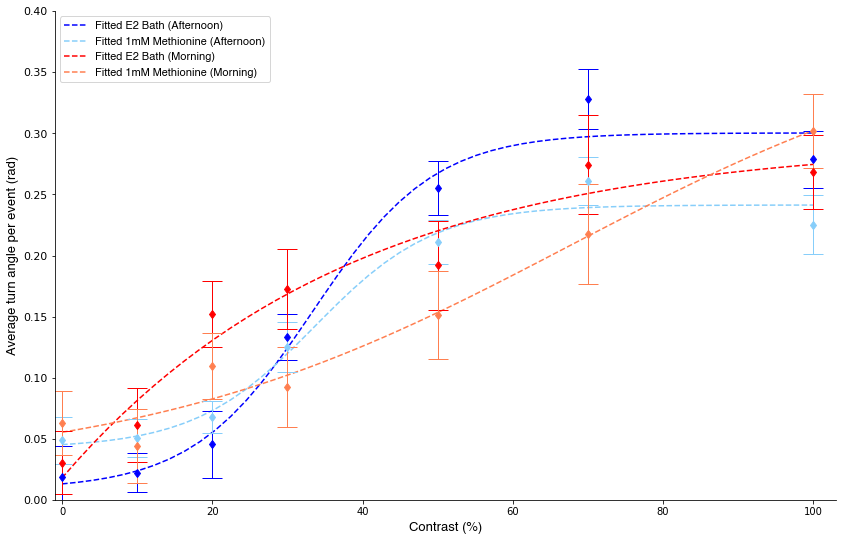

In [82]:
fig, ax = plt.subplots(1,1,figsize=(14,9))

x = [0,10,20,30,50,70,100]

# ax.plot(x,pm_e_delta,c='b',marker='d',mfc='b',label='E2 Bath (Afternoon)')
ax.plot(np.linspace(0,100,50),pm_e_delta_fit,'--b',label='Fitted E2 Bath (Afternoon)')
# ax.plot(x,pm_me_delta,c='lightskyblue',marker='d',mfc='lightskyblue',label='1mM Methionine (Afternoon)')
ax.plot(np.linspace(0,100,50),pm_me_delta_fit,c='lightskyblue',ls='--',label='Fitted 1mM Methionine (Afternoon)')
     
# ax.plot(x,am_e_delta,c='r',marker='d',mfc='r',label='E2 Bath (Morning)')
ax.plot(np.linspace(0,100,50),am_e_delta_fit,'--r',label='Fitted E2 Bath (Morning)')
# ax.plot(x,am_me_delta,c='coral',marker='d',mfc='coral',label='1mM Methionine (Morning)')
ax.plot(np.linspace(0,100,50),am_me_delta_fit,c='coral',ls='--',label='Fitted 1mM Methionine (Morning)')


ax.errorbar(x,pm_e_delta,yerr=pm_e_delta_yerr,fmt='d',color='b',capsize=10,elinewidth=1)
ax.errorbar(x,pm_me_delta,yerr=pm_me_delta_yerr,fmt='d',color='lightskyblue',capsize=10,elinewidth=1)

ax.errorbar(x,am_e_delta,yerr=am_e_delta_yerr,fmt='d',color='r',capsize=10,elinewidth=1)
ax.errorbar(x,am_me_delta,yerr=am_me_delta_yerr,fmt='d',color='coral',capsize=10,elinewidth=1)


font = font_manager.FontProperties(family='Helvetica',
                                   style='normal', size=11)
plt.legend(loc='upper left',prop=font)
plt.title('')
plt.xlabel('Contrast (%)',size=13,name='Helvetica')
plt.ylabel('Average turn angle per event (rad)',size=13,name='Helvetica')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# plt.grid(which='major',axis='y')
# x_ticks = [1, 10, 20, 30, 50, 70, 100]
# x_labels = [1, 10, 20, 30, 50, 70, 100] 
# plt.xticks(ticks=x_ticks, labels=x_labels,fontsize=11)
plt.yticks(fontsize=11)
ax.set_ylim(0,0.4)
ax.set_xlim(-1,103)
# plt.savefig('../../Dissertation/bout_angle_function.png',dpi=400,bbox_inches='tight')
plt.show()

In [84]:
# full_event_table.info()

# Delta_theta_rad OLS and ANOVA

In [85]:
bout_angle_model = ols(formula='delta_theta_rad ~ C(medium, Sum) + C(time, Sum) + C(contrast, Sum) + C(medium, Sum):\
                        C(time, Sum) + C(medium, Sum):C(contrast, Sum) + C(time, Sum):C(contrast, Sum) + \
                        C(medium, Sum):C(time, Sum):C(contrast, Sum)',data=full_event_table).fit()
anova_table_bout = sm.stats.anova_lm(bout_angle_model, typ=3)
anova_table_bout

,sum_sq,df,F,PR(>F)
Intercept,160.941010,1.0,893.048218,2.571310e-186
"C(medium, Sum)",0.629221,1.0,3.491497,6.172054e-02
"C(time, Sum)",0.031901,1.0,0.177018,6.739595e-01
"C(contrast, Sum)",60.113883,6.0,55.594486,1.319817e-67
"C(medium, Sum):C(time, Sum)",0.057306,1.0,0.317986,5.728357e-01
"C(medium, Sum):C(contrast, Sum)",1.585035,6.0,1.465872,1.855795e-01
"C(time, Sum):C(contrast, Sum)",3.321900,6.0,3.072158,5.271025e-03
"C(medium, Sum):C(time, Sum):C(contrast, Sum)",1.223891,6.0,1.131878,3.406948e-01
Residual,1472.359525,8170.0,NaN,NaN


In [86]:
am_bout_angle_model = ols(formula='delta_theta_rad ~ C(medium, Sum) + C(contrast, Sum) + \
                        C(medium, Sum):C(contrast, Sum)',data=am_events).fit()
anova_table_bout_am = sm.stats.anova_lm(am_bout_angle_model, typ=3)
anova_table_bout_am

,sum_sq,df,F,PR(>F)
Intercept,61.973184,1.0,292.575734,2.272015e-62
"C(medium, Sum)",0.399278,1.0,1.884996,1.698809e-01
"C(contrast, Sum)",19.712547,6.0,15.510506,1.430140e-17
"C(medium, Sum):C(contrast, Sum)",1.123423,6.0,0.883948,5.056519e-01
Residual,574.453914,2712.0,NaN,NaN


In [87]:
pm_bout_angle_model = ols(formula='delta_theta_rad ~ C(medium, Sum) + C(contrast, Sum) + \
                        C(medium, Sum):C(contrast, Sum)',data=pm_events).fit()
anova_table_bout_pm = sm.stats.anova_lm(pm_bout_angle_model, typ=3)
anova_table_bout_pm

,sum_sq,df,F,PR(>F)
Intercept,117.676716,1.0,715.308499,3.481361e-148
"C(medium, Sum)",0.230739,1.0,1.402567,2.363458e-01
"C(contrast, Sum)",56.397558,6.0,57.136271,8.358248e-69
"C(medium, Sum):C(contrast, Sum)",1.983977,6.0,2.009964,6.084305e-02
Residual,897.905612,5458.0,NaN,NaN


In [219]:
pg.welch_anova(data=am_events,dv='delta_theta_rad',between='medium')

,Source,ddof1,ddof2,F,p-unc,np2
0,medium,1,2704.938639,3.348346,0.067383,0.001209


In [221]:
pg.pairwise_gameshowell(data=am_events,dv='delta_theta_rad',between='medium')

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,e,me,0.173035,0.140393,0.032642,0.017839,1.829849,2704.938639,0.067383,0.070335


In [220]:
pg.welch_anova(data=pm_events,dv='delta_theta_rad',between='medium')

,Source,ddof1,ddof2,F,p-unc,np2
0,medium,1,4987.187423,3.815073,0.050849,0.000711


In [222]:
pg.pairwise_gameshowell(data=pm_events,dv='delta_theta_rad',between='medium')

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,e,me,0.163651,0.141227,0.022423,0.01148,1.953221,4987.187423,0.050849,0.053111


# Fish List Function

In [88]:
def sem_with_zero_division_exception(events,fish):
    try:
        return stats.sem(events.loc[(events['fish_n']==fish)]['latency_s'][1:]) 
    except ZeroDivisionError as e:
        return None

def make_fish_list(events):    
    fish_list = pd.DataFrame(columns=['fish_n','bouts_Hz','duration_avg','duration_sem','latency_avg',\
                                      'latency_sem','distance_avg','distance_sem','total_distance'])


    fish_list['fish_n'] = [fish for fish in events['fish_n'].unique()]
    fish_list['bouts_Hz'] = [events.loc[(events['fish_n']==fish)].max()[1]/30 \
                             for fish in events['fish_n'].unique()]
    fish_list['duration_avg'] = [np.mean(events.loc[(events['fish_n']==fish)]['duration_s']) \
                                 for fish in events['fish_n'].unique()]
    fish_list['duration_sem'] = [stats.sem(events.loc[(events['fish_n']==fish)]['duration_s']) \
                                 for fish in events['fish_n'].unique()]
    fish_list['latency_avg'] = [np.mean(events.loc[(events['fish_n']==fish)]['latency_s']) \
                                for fish in events['fish_n'].unique()]
    fish_list['latency_sem'] = [sem_with_zero_division_exception(events,fish) \
                                for fish in events['fish_n'].unique()]
    fish_list['distance_avg'] = [np.mean(events.loc[(events['fish_n']==fish)]['distance']) \
                                for fish in events['fish_n'].unique()]
    fish_list['distance_sem'] = [stats.sem(events.loc[(events['fish_n']==fish)]['distance']) \
                               for fish in events['fish_n'].unique()]
    fish_list['total_distance'] = [events.loc[(events['fish_n']==fish)]['distance'].sum() \
                                  for fish in events['fish_n'].unique()]
    # fish_list['final_cumulative_angle'] = None

    return fish_list

# Making Fish Lists 

In [89]:
fish_list_df_names = ['am_e_1','am_e_10','am_e_20','am_e_30','am_e_50','am_e_70','am_e_100',\
                      'pm_e_1','pm_e_10','pm_e_20','pm_e_30','pm_e_50','pm_e_70','pm_e_100',\
                      'am_me_1','am_me_10','am_me_20','am_me_30','am_me_50','am_me_70','am_me_100',\
                      'pm_me_1','pm_me_10','pm_me_20','pm_me_30','pm_me_50','pm_me_70','pm_me_100']

In [90]:
fish_list_dataframes = [am_e_C1_events,am_e_C10_events,am_e_C20_events,am_e_C30_events,am_e_C50_events,\
                        am_e_C70_events,am_e_C100_events,\
                        pm_e_C1_events,pm_e_C10_events,pm_e_C20_events,pm_e_C30_events,pm_e_C50_events,\
                        pm_e_C70_events,pm_e_C100_events,\
                        am_me_C1_events,am_me_C10_events,am_me_C20_events,am_me_C30_events,am_me_C50_events,\
                        am_me_C70_events,am_me_C100_events,\
                        pm_me_C1_events,pm_me_C10_events,pm_me_C20_events,pm_me_C30_events,pm_me_C50_events,\
                        pm_me_C70_events,pm_me_C100_events]

In [ ]:
full_fish_list = pd.DataFrame(columns=['fish_n','bouts_Hz','duration_avg','duration_sem','latency_avg',\
                                      'latency_sem','distance_avg','distance_sem','total_distance','time',\
                                       'medium','contrast'])

for name,df in zip(fish_list_df_names,fish_list_dataframes):
    fish_list = make_fish_list(df)
    fish_list['time'] = name.split('_')[0]
    fish_list['medium'] = name.split('_')[1]
    fish_list['contrast'] = int(name.split('_')[2])
    fish_counter += 1
    full_fish_list = pd.concat([full_fish_list,fish_list])
        
full_fish_list['fish_n'] = np.arange(1,len(full_fish_list)+1,1)
full_fish_list = full_fish_list.set_index('fish_n')

full_fish_list

In [ ]:
# full_fish_list.to_csv('../raw_data/full_fish_list.csv')

In [ ]:
full_fish_list.info()

In [ ]:
full_fish_list['bouts_Hz'] = pd.to_numeric(full_fish_list['bouts_Hz'])

In [91]:
full_fish_list = pd.read_csv('../raw_data/full_fish_list.csv')

# Bout Frequency OLS and ANOVA

In [92]:
bout_freq_model = ols(formula='bouts_Hz ~ C(medium, Sum) + C(time, Sum) + C(contrast, Sum) + C(medium, Sum):\
                        C(time, Sum) + C(medium, Sum):C(contrast, Sum) + C(time, Sum):C(contrast, Sum) + \
                        C(medium, Sum):C(time, Sum):C(contrast, Sum)',data=full_fish_list).fit()
anova_table_bout = sm.stats.anova_lm(bout_freq_model, typ=3)
anova_table_bout

,sum_sq,df,F,PR(>F)
Intercept,77.174521,1.0,3553.201381,2.710563e-307
"C(medium, Sum)",0.031047,1.0,1.429460,2.321830e-01
"C(time, Sum)",3.280228,1.0,151.025368,4.332363e-32
"C(contrast, Sum)",0.106554,6.0,0.817642,5.562785e-01
"C(medium, Sum):C(time, Sum)",0.008771,1.0,0.403840,5.252823e-01
"C(medium, Sum):C(contrast, Sum)",0.180291,6.0,1.383469,2.182891e-01
"C(time, Sum):C(contrast, Sum)",0.026461,6.0,0.203045,9.758731e-01
"C(medium, Sum):C(time, Sum):C(contrast, Sum)",0.085187,6.0,0.653688,6.871907e-01
Residual,18.635515,858.0,NaN,NaN


In [93]:
am_fish_list = full_fish_list[full_fish_list['time'] == 'am']
pm_fish_list = full_fish_list[full_fish_list['time'] == 'pm']

In [94]:
am_bout_freq_model = ols(formula='bouts_Hz ~ C(medium, Sum) + C(contrast, Sum) + \
                        C(medium, Sum):C(contrast, Sum)',data=am_fish_list).fit()
anova_table_bout_am = sm.stats.anova_lm(am_bout_freq_model, typ=3)
anova_table_bout_am

,sum_sq,df,F,PR(>F)
Intercept,21.436917,1.0,1108.163206,6.532961e-113
"C(medium, Sum)",0.032100,1.0,1.659358,1.985016e-01
"C(contrast, Sum)",0.099829,6.0,0.860096,5.244117e-01
"C(medium, Sum):C(contrast, Sum)",0.126753,6.0,1.092062,3.665199e-01
Residual,7.099449,367.0,NaN,NaN


In [95]:
pm_bout_freq_model = ols(formula='bouts_Hz ~ C(medium, Sum) + C(contrast, Sum) + \
                        C(medium, Sum):C(contrast, Sum)',data=pm_fish_list).fit()
anova_table_bout_pm = sm.stats.anova_lm(pm_bout_freq_model, typ=3)
anova_table_bout_pm

,sum_sq,df,F,PR(>F)
Intercept,64.849781,1.0,2760.147367,1.114503e-203
"C(medium, Sum)",0.003936,1.0,0.167516,6.825077e-01
"C(contrast, Sum)",0.025226,6.0,0.178946,9.825299e-01
"C(medium, Sum):C(contrast, Sum)",0.137760,6.0,0.977227,4.399355e-01
Residual,11.536066,491.0,NaN,NaN


In [185]:
am_fish_list

,fish_n,bouts_Hz,duration_avg,duration_sem,latency_avg,latency_sem,distance_avg,distance_sem,total_distance,time,medium,contrast
0,1,0.200000,0.391667,0.024141,3.678000,0.747953,26.802242,3.800349,160.813454,am,e,1
1,2,0.066667,0.395000,0.145000,8.670000,NaN,34.383574,23.017441,68.767147,am,e,1
2,3,0.300000,0.465556,0.030646,2.975000,0.568937,45.312179,4.828374,407.809608,am,e,1
3,4,0.133333,0.427500,0.046256,8.220000,2.700747,32.799947,6.768409,131.199787,am,e,1
4,5,0.166667,0.414000,0.079158,4.932500,1.941333,36.872075,8.814382,184.360374,am,e,1
...,...,...,...,...,...,...,...,...,...,...,...,...
599,600,0.066667,0.500000,0.040000,28.610000,NaN,41.913770,14.586973,83.827540,am,me,100
600,601,0.133333,0.230000,0.031358,5.616667,3.416403,18.565379,4.487539,74.261515,am,me,100
601,602,0.200000,0.421667,0.076916,2.070000,0.215893,51.239272,12.149007,307.435634,am,me,100
602,603,0.033333,0.480000,NaN,NaN,NaN,45.012470,NaN,45.012470,am,me,100


In [194]:
pg.welch_anova(data=am_fish_list,dv='bouts_Hz',between='medium')

,Source,ddof1,ddof2,F,p-unc,np2
0,medium,1,378.119462,1.914296,0.167303,0.005007


In [195]:
pg.welch_anova(data=pm_fish_list,dv='bouts_Hz',between='medium')

,Source,ddof1,ddof2,F,p-unc,np2
0,medium,1,463.730889,0.230109,0.631669,0.000463


In [96]:
am_e_fish_list = am_fish_list[am_fish_list['medium'] == 'e']
am_me_fish_list = am_fish_list[am_fish_list['medium'] == 'me']

pm_e_fish_list = pm_fish_list[pm_fish_list['medium'] == 'e']
pm_me_fish_list = pm_fish_list[pm_fish_list['medium'] == 'me']

In [97]:
am_e_1_fish_list = am_e_fish_list[am_e_fish_list['contrast'] == 1]
am_e_10_fish_list = am_e_fish_list[am_e_fish_list['contrast'] == 10]
am_e_20_fish_list = am_e_fish_list[am_e_fish_list['contrast'] == 20]
am_e_30_fish_list = am_e_fish_list[am_e_fish_list['contrast'] == 30]
am_e_50_fish_list = am_e_fish_list[am_e_fish_list['contrast'] == 50]
am_e_70_fish_list = am_e_fish_list[am_e_fish_list['contrast'] == 70]
am_e_100_fish_list = am_e_fish_list[am_e_fish_list['contrast'] == 100]

In [98]:
am_me_1_fish_list = am_me_fish_list[am_me_fish_list['contrast'] == 1]
am_me_10_fish_list = am_me_fish_list[am_me_fish_list['contrast'] == 10]
am_me_20_fish_list = am_me_fish_list[am_me_fish_list['contrast'] == 20]
am_me_30_fish_list = am_me_fish_list[am_me_fish_list['contrast'] == 30]
am_me_50_fish_list = am_me_fish_list[am_me_fish_list['contrast'] == 50]
am_me_70_fish_list = am_me_fish_list[am_me_fish_list['contrast'] == 70]
am_me_100_fish_list = am_me_fish_list[am_me_fish_list['contrast'] == 100]

In [99]:
pm_e_1_fish_list = pm_e_fish_list[pm_e_fish_list['contrast'] == 1]
pm_e_10_fish_list = pm_e_fish_list[pm_e_fish_list['contrast'] == 10]
pm_e_20_fish_list = pm_e_fish_list[pm_e_fish_list['contrast'] == 20]
pm_e_30_fish_list = pm_e_fish_list[pm_e_fish_list['contrast'] == 30]
pm_e_50_fish_list = pm_e_fish_list[pm_e_fish_list['contrast'] == 50]
pm_e_70_fish_list = pm_e_fish_list[pm_e_fish_list['contrast'] == 70]
pm_e_100_fish_list = pm_e_fish_list[pm_e_fish_list['contrast'] == 100]

In [100]:
pm_me_1_fish_list = pm_me_fish_list[pm_me_fish_list['contrast'] == 1]
pm_me_10_fish_list = pm_me_fish_list[pm_me_fish_list['contrast'] == 10]
pm_me_20_fish_list = pm_me_fish_list[pm_me_fish_list['contrast'] == 20]
pm_me_30_fish_list = pm_me_fish_list[pm_me_fish_list['contrast'] == 30]
pm_me_50_fish_list = pm_me_fish_list[pm_me_fish_list['contrast'] == 50]
pm_me_70_fish_list = pm_me_fish_list[pm_me_fish_list['contrast'] == 70]
pm_me_100_fish_list = pm_me_fish_list[pm_me_fish_list['contrast'] == 100]

# Bout Frequency Mean and SEM Calculations

In [102]:
am_e_bout_hz = [am_e_1_fish_list['bouts_Hz'].mean(),am_e_10_fish_list['bouts_Hz'].mean(),\
               am_e_20_fish_list['bouts_Hz'].mean(),am_e_30_fish_list['bouts_Hz'].mean(),\
               am_e_50_fish_list['bouts_Hz'].mean(),am_e_70_fish_list['bouts_Hz'].mean(),\
               am_e_100_fish_list['bouts_Hz'].mean()]
am_me_bout_hz = [am_me_1_fish_list['bouts_Hz'].mean(),am_me_10_fish_list['bouts_Hz'].mean(),\
               am_me_20_fish_list['bouts_Hz'].mean(),am_me_30_fish_list['bouts_Hz'].mean(),\
               am_me_50_fish_list['bouts_Hz'].mean(),am_me_70_fish_list['bouts_Hz'].mean(),\
               am_me_100_fish_list['bouts_Hz'].mean()]
pm_e_bout_hz = [pm_e_1_fish_list['bouts_Hz'].mean(),pm_e_10_fish_list['bouts_Hz'].mean(),\
               pm_e_20_fish_list['bouts_Hz'].mean(),pm_e_30_fish_list['bouts_Hz'].mean(),\
               pm_e_50_fish_list['bouts_Hz'].mean(),pm_e_70_fish_list['bouts_Hz'].mean(),\
               pm_e_100_fish_list['bouts_Hz'].mean()]
pm_me_bout_hz = [pm_me_1_fish_list['bouts_Hz'].mean(),pm_me_10_fish_list['bouts_Hz'].mean(),\
               pm_me_20_fish_list['bouts_Hz'].mean(),pm_me_30_fish_list['bouts_Hz'].mean(),\
               pm_me_50_fish_list['bouts_Hz'].mean(),pm_me_70_fish_list['bouts_Hz'].mean(),\
               pm_me_100_fish_list['bouts_Hz'].mean()]

In [103]:
am_e_1_bout_hz_sem = stats.sem(am_e_1_fish_list['bouts_Hz'])
am_e_10_bout_hz_sem = stats.sem(am_e_10_fish_list['bouts_Hz'])
am_e_20_bout_hz_sem = stats.sem(am_e_20_fish_list['bouts_Hz'])
am_e_30_bout_hz_sem = stats.sem(am_e_30_fish_list['bouts_Hz'])
am_e_50_bout_hz_sem = stats.sem(am_e_50_fish_list['bouts_Hz'])
am_e_70_bout_hz_sem = stats.sem(am_e_70_fish_list['bouts_Hz'])
am_e_100_bout_hz_sem = stats.sem(am_e_100_fish_list['bouts_Hz'])

In [104]:
am_me_1_bout_hz_sem = stats.sem(am_me_1_fish_list['bouts_Hz'])
am_me_10_bout_hz_sem = stats.sem(am_me_10_fish_list['bouts_Hz'])
am_me_20_bout_hz_sem = stats.sem(am_me_20_fish_list['bouts_Hz'])
am_me_30_bout_hz_sem = stats.sem(am_me_30_fish_list['bouts_Hz'])
am_me_50_bout_hz_sem = stats.sem(am_me_50_fish_list['bouts_Hz'])
am_me_70_bout_hz_sem = stats.sem(am_me_70_fish_list['bouts_Hz'])
am_me_100_bout_hz_sem = stats.sem(am_me_100_fish_list['bouts_Hz'])

In [105]:
pm_e_1_bout_hz_sem = stats.sem(pm_e_1_fish_list['bouts_Hz'])
pm_e_10_bout_hz_sem = stats.sem(pm_e_10_fish_list['bouts_Hz'])
pm_e_20_bout_hz_sem = stats.sem(pm_e_20_fish_list['bouts_Hz'])
pm_e_30_bout_hz_sem = stats.sem(pm_e_30_fish_list['bouts_Hz'])
pm_e_50_bout_hz_sem = stats.sem(pm_e_50_fish_list['bouts_Hz'])
pm_e_70_bout_hz_sem = stats.sem(pm_e_70_fish_list['bouts_Hz'])
pm_e_100_bout_hz_sem = stats.sem(pm_e_100_fish_list['bouts_Hz'])

In [106]:
pm_me_1_bout_hz_sem = stats.sem(pm_me_1_fish_list['bouts_Hz'])
pm_me_10_bout_hz_sem = stats.sem(pm_me_10_fish_list['bouts_Hz'])
pm_me_20_bout_hz_sem = stats.sem(pm_me_20_fish_list['bouts_Hz'])
pm_me_30_bout_hz_sem = stats.sem(pm_me_30_fish_list['bouts_Hz'])
pm_me_50_bout_hz_sem = stats.sem(pm_me_50_fish_list['bouts_Hz'])
pm_me_70_bout_hz_sem = stats.sem(pm_me_70_fish_list['bouts_Hz'])
pm_me_100_bout_hz_sem = stats.sem(pm_me_100_fish_list['bouts_Hz'])

In [107]:
am_e_bout_hz_yerr = [am_e_1_bout_hz_sem,am_e_10_bout_hz_sem,am_e_20_bout_hz_sem,am_e_30_bout_hz_sem,\
                     am_e_50_bout_hz_sem,am_e_70_bout_hz_sem,am_e_100_bout_hz_sem]
am_me_bout_hz_yerr = [am_me_1_bout_hz_sem,am_me_10_bout_hz_sem,am_me_20_bout_hz_sem,am_me_30_bout_hz_sem,\
                      am_me_50_bout_hz_sem,am_me_70_bout_hz_sem,am_me_100_bout_hz_sem]

pm_e_bout_hz_yerr = [pm_e_1_bout_hz_sem,pm_e_10_bout_hz_sem,pm_e_20_bout_hz_sem,pm_e_30_bout_hz_sem,\
                     pm_e_50_bout_hz_sem,pm_e_70_bout_hz_sem,pm_e_100_bout_hz_sem]
pm_me_bout_hz_yerr = [pm_me_1_bout_hz_sem,pm_me_10_bout_hz_sem,pm_me_20_bout_hz_sem,pm_me_30_bout_hz_sem,\
                      pm_me_50_bout_hz_sem,pm_me_70_bout_hz_sem,pm_me_100_bout_hz_sem]

# Fitting a Straight Line Functions

In [108]:
def straight_line(x, A, B): # this is your 'straight line' y=f(x)
    return np.multiply(A,x) + B

# popt, pcov = curve_fit(f, x, y) # your data x, y to fit

def fit_straight_line(ydata):
    xdata = [1,10,20,30,50,70,100]
#     p0 = [max(ydata), np.median(xdata),1,min(ydata)] # this is an mandatory initial guess
    popt, pcov = curve_fit(straight_line, xdata, ydata)
    y = straight_line(xdata, popt[0],popt[1])
    new_x = np.linspace(0,100,50)
    new_y = straight_line(new_x, popt[0],popt[1])
    return new_y

In [109]:
am_e_bout_hz_fit = fit_straight_line(am_e_bout_hz)
am_me_bout_hz_fit = fit_straight_line(am_me_bout_hz)
pm_e_bout_hz_fit = fit_straight_line(pm_e_bout_hz)
pm_me_bout_hz_fit = fit_straight_line(pm_me_bout_hz)

# Bout Frequency Plot

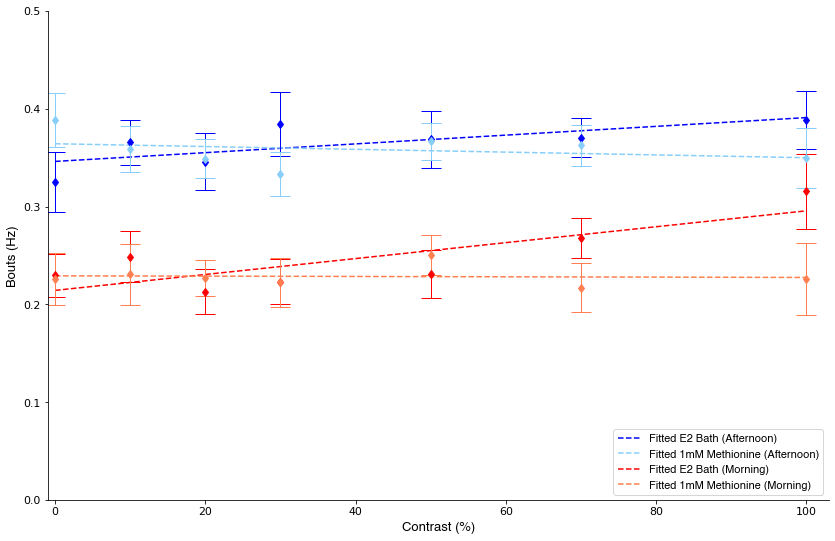

In [110]:
fig, ax = plt.subplots(1,1,figsize=(14,9))

x = [0,10,20,30,50,70,100]

# ax.plot(x,pm_e_bout_hz,c='b',marker='d',mfc='b',label='E2 Bath (Afternoon)')
ax.plot(np.linspace(0,100,50),pm_e_bout_hz_fit,'--b',label='Fitted E2 Bath (Afternoon)')
# ax.plot(x,pm_me_bout_hz,c='lightskyblue',marker='d',mfc='lightskyblue',label='1mM Methionine (Afternoon)')
ax.plot(np.linspace(0,100,50),pm_me_bout_hz_fit,c='lightskyblue',ls='--',label='Fitted 1mM Methionine (Afternoon)')
     
# ax.plot(x,am_e_bout_hz,c='r',marker='d',mfc='r',label='E2 Bath (Morning)')
ax.plot(np.linspace(0,100,50),am_e_bout_hz_fit,'--r',label='Fitted E2 Bath (Morning)')
# ax.plot(x,am_me_bout_hz,c='coral',marker='d',mfc='coral',label='1mM Methionine (Morning)')
ax.plot(np.linspace(0,100,50),am_me_bout_hz_fit,c='coral',ls='--',label='Fitted 1mM Methionine (Morning)')


ax.errorbar(x,pm_e_bout_hz,yerr=pm_e_bout_hz_yerr,fmt='d',color='b',capsize=10,elinewidth=1)
ax.errorbar(x,pm_me_bout_hz,yerr=pm_me_bout_hz_yerr,fmt='d',color='lightskyblue',capsize=10,elinewidth=1)

ax.errorbar(x,am_e_bout_hz,yerr=am_e_bout_hz_yerr,fmt='d',color='r',capsize=10,elinewidth=1)
ax.errorbar(x,am_me_bout_hz,yerr=am_me_bout_hz_yerr,fmt='d',color='coral',capsize=10,elinewidth=1)


font = font_manager.FontProperties(family='Helvetica',
                                   style='normal', size=11)
plt.legend(loc='lower right',prop=font)
plt.title('')
plt.xlabel('Contrast (%)',size=13,name='Helvetica')
plt.ylabel('Bouts (Hz)',size=13,name='Helvetica')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# plt.grid(which='major',axis='y')
# x_ticks = [1, 10, 20, 30, 50, 70, 100]
# x_labels = [1, 10, 20, 30, 50, 70, 100] 
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
ax.set_ylim(0,0.5)
ax.set_xlim(-1,103)
plt.savefig('../../Dissertation/bout_freq_function.png',dpi=400,bbox_inches='tight')
plt.show()

# Interbout Interval OLS and ANOVA

In [153]:
full_fish_list

,fish_n,bouts_Hz,duration_avg,duration_sem,latency_avg,latency_sem,distance_avg,distance_sem,total_distance,time,medium,contrast
0,1,0.200000,0.391667,0.024141,3.678000,0.747953,26.802242,3.800349,160.813454,am,e,1
1,2,0.066667,0.395000,0.145000,8.670000,NaN,34.383574,23.017441,68.767147,am,e,1
2,3,0.300000,0.465556,0.030646,2.975000,0.568937,45.312179,4.828374,407.809608,am,e,1
3,4,0.133333,0.427500,0.046256,8.220000,2.700747,32.799947,6.768409,131.199787,am,e,1
4,5,0.166667,0.414000,0.079158,4.932500,1.941333,36.872075,8.814382,184.360374,am,e,1
...,...,...,...,...,...,...,...,...,...,...,...,...
881,882,0.400000,0.423333,0.041966,2.035455,0.297561,30.414870,5.903734,364.978435,pm,me,100
882,883,0.600000,0.468889,0.042855,1.057647,0.163056,161.615916,40.061437,2909.086490,pm,me,100
883,884,0.600000,0.540556,0.040781,1.158235,0.144968,108.355805,14.558205,1950.404486,pm,me,100
884,885,0.300000,0.537778,0.022899,1.417500,0.183028,82.255455,14.195883,740.299098,pm,me,100


In [154]:
interbout_model = ols(formula='latency_avg ~ C(medium, Sum) + C(time, Sum) + C(contrast, Sum) + C(medium, Sum):\
                        C(time, Sum) + C(medium, Sum):C(contrast, Sum) + C(time, Sum):C(contrast, Sum) + \
                        C(medium, Sum):C(time, Sum):C(contrast, Sum)',data=full_fish_list).fit()
anova_table_interbout = sm.stats.anova_lm(interbout_model, typ=3)
anova_table_interbout

,sum_sq,df,F,PR(>F)
Intercept,8757.508097,1.0,1347.207230,7.687783e-176
"C(medium, Sum)",3.195845,1.0,0.491631,4.833975e-01
"C(time, Sum)",590.845170,1.0,90.892395,1.634974e-20
"C(contrast, Sum)",39.605057,6.0,1.015438,4.137403e-01
"C(medium, Sum):C(time, Sum)",0.923066,1.0,0.141999,7.063979e-01
"C(medium, Sum):C(contrast, Sum)",83.898756,6.0,2.151088,4.568458e-02
"C(time, Sum):C(contrast, Sum)",29.477329,6.0,0.755772,6.049188e-01
"C(medium, Sum):C(time, Sum):C(contrast, Sum)",23.471168,6.0,0.601779,7.290783e-01
Residual,5382.406316,828.0,NaN,NaN


In [155]:
am_interbout_model = ols(formula='latency_avg ~ C(medium, Sum) + C(contrast, Sum) + \
                        C(medium, Sum):C(contrast, Sum)',data=am_fish_list).fit()
anova_table_interbout_am = sm.stats.anova_lm(am_interbout_model, typ=3)
anova_table_interbout_am

,sum_sq,df,F,PR(>F)
Intercept,6016.654737,1.0,551.223208,1.397892e-73
"C(medium, Sum)",0.296037,1.0,0.027122,8.692865e-01
"C(contrast, Sum)",45.086387,6.0,0.688441,6.591093e-01
"C(medium, Sum):C(contrast, Sum)",82.363960,6.0,1.257646,2.764276e-01
Residual,3776.623531,346.0,NaN,NaN


In [156]:
pm_interbout_model = ols(formula='latency_avg ~ C(medium, Sum) + C(contrast, Sum) + \
                        C(medium, Sum):C(contrast, Sum)',data=pm_fish_list).fit()
anova_table_interbout_pm = sm.stats.anova_lm(pm_interbout_model, typ=3)
anova_table_interbout_pm

,sum_sq,df,F,PR(>F)
Intercept,2839.406702,1.0,852.290885,1.218927e-108
"C(medium, Sum)",4.469526,1.0,1.341596,2.473263e-01
"C(contrast, Sum)",19.772586,6.0,0.989173,4.318464e-01
"C(medium, Sum):C(contrast, Sum)",14.332627,6.0,0.717026,6.360410e-01
Residual,1605.782785,482.0,NaN,NaN


In [200]:
pg.welch_anova(data=am_fish_list,dv='latency_avg',between='medium')

,Source,ddof1,ddof2,F,p-unc,np2
0,medium,1,342.475196,0.066583,0.796533,0.000188


In [201]:
pg.welch_anova(data=pm_fish_list,dv='latency_avg',between='medium')

,Source,ddof1,ddof2,F,p-unc,np2
0,medium,1,468.079388,1.375984,0.241383,0.002766


# Interbout Intervals Mean & SEM Calculations

In [157]:
am_e_interbout = [am_e_1_fish_list['latency_avg'].mean(),am_e_10_fish_list['latency_avg'].mean(),\
               am_e_20_fish_list['latency_avg'].mean(),am_e_30_fish_list['latency_avg'].mean(),\
               am_e_50_fish_list['latency_avg'].mean(),am_e_70_fish_list['latency_avg'].mean(),\
               am_e_100_fish_list['latency_avg'].mean()]
am_me_interbout = [am_me_1_fish_list['latency_avg'].mean(),am_me_10_fish_list['latency_avg'].mean(),\
               am_me_20_fish_list['latency_avg'].mean(),am_me_30_fish_list['latency_avg'].mean(),\
               am_me_50_fish_list['latency_avg'].mean(),am_me_70_fish_list['latency_avg'].mean(),\
               am_me_100_fish_list['latency_avg'].mean()]
pm_e_interbout = [pm_e_1_fish_list['latency_avg'].mean(),pm_e_10_fish_list['latency_avg'].mean(),\
               pm_e_20_fish_list['latency_avg'].mean(),pm_e_30_fish_list['latency_avg'].mean(),\
               pm_e_50_fish_list['latency_avg'].mean(),pm_e_70_fish_list['latency_avg'].mean(),\
               pm_e_100_fish_list['latency_avg'].mean()]
pm_me_interbout = [pm_me_1_fish_list['latency_avg'].mean(),pm_me_10_fish_list['latency_avg'].mean(),\
               pm_me_20_fish_list['latency_avg'].mean(),pm_me_30_fish_list['latency_avg'].mean(),\
               pm_me_50_fish_list['latency_avg'].mean(),pm_me_70_fish_list['latency_avg'].mean(),\
               pm_me_100_fish_list['latency_avg'].mean()]

In [169]:
am_e_1_interbout_sem = stats.sem(am_e_1_fish_list['latency_avg'],nan_policy='omit')
am_e_10_interbout_sem = stats.sem(am_e_10_fish_list['latency_avg'],nan_policy='omit')
am_e_20_interbout_sem = stats.sem(am_e_20_fish_list['latency_avg'],nan_policy='omit')
am_e_30_interbout_sem = stats.sem(am_e_30_fish_list['latency_avg'],nan_policy='omit')
am_e_50_interbout_sem = stats.sem(am_e_50_fish_list['latency_avg'],nan_policy='omit')
am_e_70_interbout_sem = stats.sem(am_e_70_fish_list['latency_avg'],nan_policy='omit')
am_e_100_interbout_sem = stats.sem(am_e_100_fish_list['latency_avg'],nan_policy='omit')

In [170]:
am_me_1_interbout_sem = stats.sem(am_me_1_fish_list['latency_avg'],nan_policy='omit')
am_me_10_interbout_sem = stats.sem(am_me_10_fish_list['latency_avg'],nan_policy='omit')
am_me_20_interbout_sem = stats.sem(am_me_20_fish_list['latency_avg'],nan_policy='omit')
am_me_30_interbout_sem = stats.sem(am_me_30_fish_list['latency_avg'],nan_policy='omit')
am_me_50_interbout_sem = stats.sem(am_me_50_fish_list['latency_avg'],nan_policy='omit')
am_me_70_interbout_sem = stats.sem(am_me_70_fish_list['latency_avg'],nan_policy='omit')
am_me_100_interbout_sem = stats.sem(am_me_100_fish_list['latency_avg'],nan_policy='omit')

In [171]:
pm_e_1_interbout_sem = stats.sem(pm_e_1_fish_list['latency_avg'],nan_policy='omit')
pm_e_10_interbout_sem = stats.sem(pm_e_10_fish_list['latency_avg'],nan_policy='omit')
pm_e_20_interbout_sem = stats.sem(pm_e_20_fish_list['latency_avg'],nan_policy='omit')
pm_e_30_interbout_sem = stats.sem(pm_e_30_fish_list['latency_avg'],nan_policy='omit')
pm_e_50_interbout_sem = stats.sem(pm_e_50_fish_list['latency_avg'],nan_policy='omit')
pm_e_70_interbout_sem = stats.sem(pm_e_70_fish_list['latency_avg'],nan_policy='omit')
pm_e_100_interbout_sem = stats.sem(pm_e_100_fish_list['latency_avg'],nan_policy='omit')

In [172]:
pm_me_1_interbout_sem = stats.sem(pm_me_1_fish_list['latency_avg'],nan_policy='omit')
pm_me_10_interbout_sem = stats.sem(pm_me_10_fish_list['latency_avg'],nan_policy='omit')
pm_me_20_interbout_sem = stats.sem(pm_me_20_fish_list['latency_avg'],nan_policy='omit')
pm_me_30_interbout_sem = stats.sem(pm_me_30_fish_list['latency_avg'],nan_policy='omit')
pm_me_50_interbout_sem = stats.sem(pm_me_50_fish_list['latency_avg'],nan_policy='omit')
pm_me_70_interbout_sem = stats.sem(pm_me_70_fish_list['latency_avg'],nan_policy='omit')
pm_me_100_interbout_sem = stats.sem(pm_me_100_fish_list['latency_avg'],nan_policy='omit')

In [173]:
am_e_interbout_yerr = [am_e_1_interbout_sem,am_e_10_interbout_sem,am_e_20_interbout_sem,am_e_30_interbout_sem,\
                     am_e_50_interbout_sem,am_e_70_interbout_sem,am_e_100_interbout_sem]
am_me_interbout_yerr = [am_me_1_interbout_sem,am_me_10_interbout_sem,am_me_20_interbout_sem,am_me_30_interbout_sem,\
                      am_me_50_interbout_sem,am_me_70_interbout_sem,am_me_100_interbout_sem]

pm_e_interbout_yerr = [pm_e_1_interbout_sem,pm_e_10_interbout_sem,pm_e_20_interbout_sem,pm_e_30_interbout_sem,\
                     pm_e_50_interbout_sem,pm_e_70_interbout_sem,pm_e_100_interbout_sem]
pm_me_interbout_yerr = [pm_me_1_interbout_sem,pm_me_10_interbout_sem,pm_me_20_interbout_sem,pm_me_30_interbout_sem,\
                      pm_me_50_interbout_sem,pm_me_70_interbout_sem,pm_me_100_interbout_sem]

In [182]:
am_e_interbout_fit = fit_straight_line(am_e_interbout)
am_me_interbout_fit = fit_straight_line(am_me_interbout)
pm_e_interbout_fit = fit_straight_line(pm_e_interbout)
pm_me_interbout_fit = fit_straight_line(pm_me_interbout)

# Interbout Interval Plot

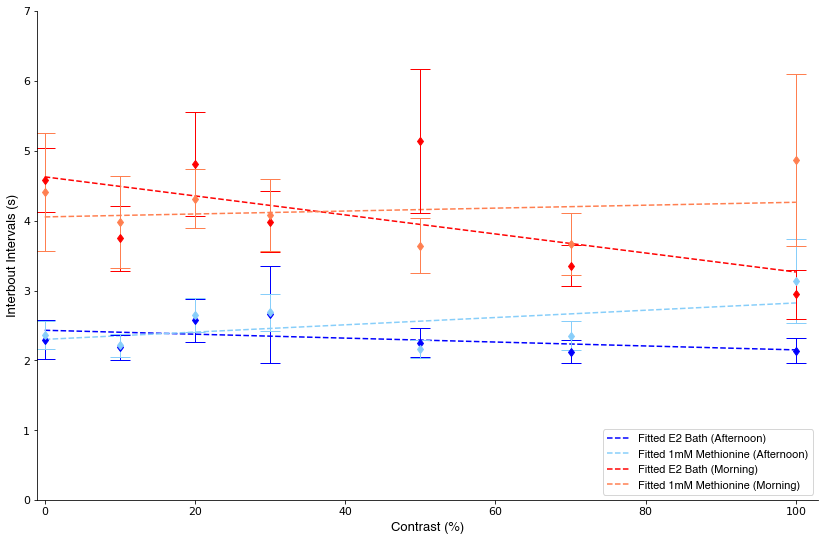

In [184]:
fig, ax = plt.subplots(1,1,figsize=(14,9))

x = [0,10,20,30,50,70,100]

# ax.plot(x,pm_e_interbout,c='b',marker='d',mfc='b',label='E2 Bath (Afternoon)')
ax.plot(np.linspace(0,100,50),pm_e_interbout_fit,'--b',label='Fitted E2 Bath (Afternoon)')
# ax.plot(x,pm_me_interbout,c='lightskyblue',marker='d',mfc='lightskyblue',label='1mM Methionine (Afternoon)')
ax.plot(np.linspace(0,100,50),pm_me_interbout_fit,c='lightskyblue',ls='--',label='Fitted 1mM Methionine (Afternoon)')
     
# ax.plot(x,am_e_interbout,c='r',marker='d',mfc='r',label='E2 Bath (Morning)')
ax.plot(np.linspace(0,100,50),am_e_interbout_fit,'--r',label='Fitted E2 Bath (Morning)')
# ax.plot(x,am_me_interbout,c='coral',marker='d',mfc='coral',label='1mM Methionine (Morning)')
ax.plot(np.linspace(0,100,50),am_me_interbout_fit,c='coral',ls='--',label='Fitted 1mM Methionine (Morning)')


ax.errorbar(x,pm_e_interbout,yerr=pm_e_interbout_yerr,fmt='d',color='b',capsize=10,elinewidth=1)
ax.errorbar(x,pm_me_interbout,yerr=pm_me_interbout_yerr,fmt='d',color='lightskyblue',capsize=10,elinewidth=1)

ax.errorbar(x,am_e_interbout,yerr=am_e_interbout_yerr,fmt='d',color='r',capsize=10,elinewidth=1)
ax.errorbar(x,am_me_interbout,yerr=am_me_interbout_yerr,fmt='d',color='coral',capsize=10,elinewidth=1)


font = font_manager.FontProperties(family='Helvetica',
                                   style='normal', size=11)
plt.legend(loc='lower right',prop=font)
plt.title('')
plt.xlabel('Contrast (%)',size=13,name='Helvetica')
plt.ylabel('Interbout Intervals (s)',size=13,name='Helvetica')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# plt.grid(which='major',axis='y')
# x_ticks = [1, 10, 20, 30, 50, 70, 100]
# x_labels = [1, 10, 20, 30, 50, 70, 100] 
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
ax.set_ylim(0,7)
ax.set_xlim(-1,103)
# plt.savefig('../../Dissertation/interbout_interval_function.png',dpi=400,bbox_inches='tight')
plt.show()